## ** The Improved Power Disaggregation (Non-intrusive Load Monitoring) **

- Author : Gyubaek Kim (database.kim@yonsei.ac.kr)
- Description
  * Building a common pre-trained disaggregation model for target appliances is descrbied. Finally, a result processing scheme is introduced.
- License
   * All rights reserved. No part of this code may be reproduced or transmitted in any form or by any means, or utilized by any information storage and retrieval system without written permission from the copyright owner. You can use this source code for free projects only. I will not allow commercial use of this code. I am not allowing anyone to modify any or all parts of the source code for commercial purposes. By using my source code, you agree to the following: 
       * 1. You will not distribute any or all parts of this source code for commercial use 
       * 2. You will cite me as the original creator of this source code. 
       * 3. You will inform me of its use before you use any or all parts of this source code. 
   For use of any or all parts of this source code, email me. This source code is provided free to use for everybody provided this is used non-commercially. Violators of this agreement will be subject to legal action by the author. If you see commercial applications or software using any or all parts of this source code, inform me.  

In [3]:
#### NIMLTK as common framework ####
from nilmtk.utils import find_nearest
from nilmtk.feature_detectors import cluster
from nilmtk.legacy.disaggregate import Disaggregator
from nilmtk.datastore import HDFDataStore
from nilmtk import DataSet

#### Benchmark Resource ####
from benchmark.rnndisaggregator import RNNDisaggregator
from benchmark.grudisaggregator import GRUDisaggregator
from benchmark.windowgrudisaggregator import WindowGRUDisaggregator
from benchmark.daedisaggregator import DAEDisaggregator
from benchmark.shortseq2pointdisaggregator import ShortSeq2PointDisaggregator
from benchmark.metrics import recall_precision_accuracy_f1, recall_precision_accuracy_f1_2, relative_error_total_energy, mean_absolute_error

from work.benchmark.rnndisaggregator_fe import RNNDisaggregatorFE
from work.benchmark.grudisaggregator_fe import GRUDisaggregatorFE
from work.benchmark.windowgrudisaggregator_fe import WindowGRUDisaggregatorFE
from work.benchmark.daedisaggregator_fe import DAEDisaggregatorFE
from work.benchmark.shortseq2pointdisaggregator_fe import ShortSeq2PointDisaggregatorFE

#### Our Model ####
from work.dtdisaggregator import DTDisaggregator
from work.utils import checkSimilarity

import pandas as pd
import numpy as np
import h5py
import numpy.random
import time
import datetime
import math
import itertools
import warnings

from scipy.signal import find_peaks, find_peaks_cwt
from sklearn.metrics import precision_score
from scipy import stats

from matplotlib import rcParams
import matplotlib.pyplot as plt

numpy.random.seed(42)
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['figure.figsize'] = (23, 10)
plt.rcParams['axes.grid'] = True 

/home/kgbmanse/anaconda3/envs/nilm/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


#### Configuration

In [4]:
###############################################################
# Common
###############################################################

DATA_FILE = '../enertalk/enertalk-converted/enertalk.h5'

#appliances = ['television', 'washing machine', 'rice cooker', 'water filter', 'microwave']
target_appliance = 'rice cooker'
#target_appliance = 'washing machine'

EPOCHS = 1

PROFILING = True

###############################################################
# target_appliance = rice cooker
###############################################################

test_plan = [
    {'home_id':1,'sdate':'2017-01-01 00:00:00','edate':'2017-01-15 00:00:00','train':True},
    {'home_id':2,'sdate':'2017-01-01 00:00:00','edate':'2017-01-15 00:00:00','train':True},
    {'home_id':10,'sdate':'2017-01-01 00:00:00','edate':'2017-01-15 00:00:00','train':True},
    {'home_id':13,'sdate':'2017-01-01 00:00:00','edate':'2017-01-15 00:00:00','train':True},
    {'home_id':14,'sdate':'2017-01-01 00:00:00','edate':'2017-01-15 00:00:00','train':False},
    {'home_id':18,'sdate':'2017-01-01 00:00:00','edate':'2017-01-15 00:00:00','train':True},
    {'home_id':22,'sdate':'2017-01-01 00:00:00','edate':'2017-01-15 00:00:00','train':True},
    {'home_id':3,'sdate':'2016-10-01 00:00:00','edate':'2016-10-15 00:00:00','train':True},
    {'home_id':5,'sdate':'2016-10-01 00:00:00','edate':'2016-10-15 00:00:00','train':True},
    {'home_id':21,'sdate':'2017-04-01 00:00:00','edate':'2017-04-15 00:00:00','train':True},
    {'home_id':6,'sdate':'2016-10-01 00:00:00','edate':'2016-10-15 00:00:00','train':False},
    {'home_id':9,'sdate':'2016-12-01 00:00:00','edate':'2016-12-15 00:00:00','train':False},
    {'home_id':12,'sdate':'2017-04-01 00:00:00','edate':'2017-04-15 00:00:00','train':True}    
]

###############################################################
# target_appliance = washing machine
###############################################################

#test_plan = [
#    {'home_id':5,'sdate':'2016-09-01 00:00:00','edate':'2016-09-15 00:00:00','train':True},
#    {'home_id':19,'sdate':'2016-09-01 00:00:00','edate':'2016-09-15 00:00:00','train':True},
#    {'home_id':7,'sdate':'2016-10-01 00:00:00','edate':'2016-10-15 00:00:00','train':True},
#    {'home_id':1,'sdate':'2016-12-01 00:00:00','edate':'2016-12-15 00:00:00','train':True},
#    {'home_id':2,'sdate':'2016-12-01 00:00:00','edate':'2016-12-15 00:00:00','train':True},
#    {'home_id':4,'sdate':'2016-12-01 00:00:00','edate':'2016-12-15 00:00:00','train':True},
#    {'home_id':18,'sdate':'2016-12-01 00:00:00','edate':'2016-12-15 00:00:00','train':True},
#    {'home_id':22,'sdate':'2016-12-01 00:00:00','edate':'2016-12-15 00:00:00','train':True},
#    {'home_id':6,'sdate':'2016-09-01 00:00:00','edate':'2016-09-15 00:00:00','train':False},
#    {'home_id':3,'sdate':'2016-10-01 00:00:00','edate':'2016-10-15 00:00:00','train':False},
#    {'home_id':9,'sdate':'2016-12-01 00:00:00','edate':'2016-12-15 00:00:00','train':False}
#]

###############################################################
# 6 sec sampling
###############################################################

TRAIN_SAMPLE_PERIOD = 6
TEST_SAMPLE_PERIOD = 6

LEAST_AMOUNT = 10  # baseline used in NILMTK (watt)
ROLL_WINDOW_SIZE = 10
MIN_WIDTH = 10     # general information (min)
MAX_WIDTH = 60*24*7 # literal
MIN_HEIGHT = 200   # general information for rice cooker (watt)
#MIN_HEIGHT = 100   # general information for washing machine (watt)
MAX_HEIGHT = 9999 # literal

NUM_IN_MINUTE = 10 # 10 points with 6-sec sampling in one minute

###############################################################
# 15 min sampling
###############################################################

#TRAIN_SAMPLE_PERIOD = 900
#TEST_SAMPLE_PERIOD = 900

#LEAST_AMOUNT = 10  # baseline used in NILMTK (watt)
#ROLL_WINDOW_SIZE = 1
#MIN_WIDTH = 1     # general information (15-min unit)
#MAX_WIDTH = 4*24*7 # literal
#MIN_HEIGHT = 200   # general information (watt)
#MAX_HEIGHT = 9999 # literal

#NUM_IN_MINUTE = 1

#### Utility Functions

In [5]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
def compute_result(gt, pred):
    
    if len(gt) > 0 and len(pred) > 0:
    
        print('recall = ' + str(recall_score(gt, pred)))
        print('precision = ' + str(precision_score(gt, pred)))
        print('accuracy = ' + str(accuracy_score(gt, pred)))
        print('f1 = ' + str(f1_score(gt, pred)))

In [6]:
def get_series_data(meter, period):

    meter_power_series = meter.power_series(sample_period=period)
    chunk = next(meter_power_series)
    chunk.fillna(0, inplace=True)
    
    return chunk

In [7]:
def extract_activation(home_id, chunk, least_amount, width_min, width_max, height_min, height_max):
    
    chunk = chunk.rolling(window=ROLL_WINDOW_SIZE, center=True, min_periods=1).sum()
    print(chunk)
    
    least_amount = least_amount * ROLL_WINDOW_SIZE
    height_min = height_min * ROLL_WINDOW_SIZE
    height_max = height_max * ROLL_WINDOW_SIZE
    
    chunk[chunk < least_amount] = 0

    r_list = []

    s_idx = -1
    e_idx = -1
    
    for i in range(len(chunk)):

        if chunk[i] >= least_amount and s_idx < 0:
            s_idx = i
            
        if i != (len(chunk)-1) and chunk[i] >= least_amount and s_idx >= 0:
            continue
            
        if (chunk[i] < least_amount and s_idx >= 0) or (i == (len(chunk)-1) and chunk[i] >= least_amount and s_idx >= 0):
            e_idx = i
            
            diff = e_idx - s_idx
            
            activation = chunk[s_idx:e_idx]
            max_activation = max(activation)
            
            if diff >= width_min and diff < width_max and max_activation >= height_min and max_activation < height_max:

                r_list.append({'home_id':home_id,
                               'start_idx':chunk.index[s_idx].strftime('%Y-%m-%d %X'), 
                               'end_idx':chunk.index[e_idx].strftime('%Y-%m-%d %X'),
                               'width':diff,
                               'height':int(max_activation/ROLL_WINDOW_SIZE)
                              })

            s_idx = -1
            e_idx = -1
            
    return r_list

In [8]:
# Function to exclude outlier on one-dimentional datasets.
# source : https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623
def exclude_anomalies(data, std):
    
    result = []
    
    # Set upper and lower limit to 3 standard deviation
    data_std = np.std(data)
    data_mean = np.mean(data)
    anomaly_cut_off = data_std * std
    
    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off
    
    # Generate outliers
    for d in data:
        
        if d > lower_limit and d < upper_limit:
            result.append(d)
            
    return result

In [9]:
def scatter_activations(alist):
    #print(alist)
    
    for i in range(len(alist)):        

        w = []
        h = []

        for j in range(len(alist[i])):
            w.append(alist[i][j]['width'])
            h.append(alist[i][j]['height'])

        plt.scatter(w, h, s=150)

        for k in range(len(w)):
            if (k % 4) == 0:
                plt.annotate(str(alist[i][j]['home_id']), (w[k]+80, h[k] + 30))
            elif (k % 4) == 1:
                plt.annotate(str(alist[i][j]['home_id']), (w[k]+80, h[k] - 30))                
            elif (k % 4) == 2:    
                plt.annotate(str(alist[i][j]['home_id']), (w[k]-80, h[k] + 30))                
            else:
                plt.annotate(str(alist[i][j]['home_id']), (w[k]-80, h[k] - 30))

    plt.legend()
    plt.xlabel('width')
    plt.ylabel('height')
    plt.show()

In [10]:
def plot_activation_time(alist):
    
    fig, ax = plt.subplots()
    
    data = []
    
    for i in range(len(alist)):        

        hour = []

        for j in range(len(alist[i])):
            
            t_s = (datetime.datetime.strptime(alist[i][j]['start_idx'], '%Y-%m-%d %X')).hour
            hour.append(t_s)
      
        data.append(hour)
        
    ax.boxplot(data)
    plt.show()

### Result Processing
* This process is executed after disaggregation is done.

In [11]:
plt.rcParams['axes.grid'] = True 
def result_process(home_id, total, ground_truth, predicted):
   
    if ground_truth is not None:
        gt = ground_truth.power_series_all_data(sample_period=TEST_SAMPLE_PERIOD)
     
    if predicted is not None:
        pred = predicted.power_series_all_data(sample_period=TEST_SAMPLE_PERIOD)
    
    ix = gt.index.intersection(pred.index)           
    gt = gt[ix]
    pred = pred[ix]
    
    t = total.power_series_all_data()    
    
#    plt.plot(t, linewidth=2)
#    plt.plot(gt, linewidth=2)
#    plt.plot(pred, linewidth=2)
#    plt.legend(['Total','Appliance (gt)', 'Appliance (pred)'])  
#    plt.show()
    
    #############
                
    pred[pred < LEAST_AMOUNT] = 0
    
    plt.plot(gt, linewidth=2)
    plt.plot(pred, linewidth=2)
    plt.legend(['Appliance (gt)', 'Appliance (pred)'])    
    plt.show()    
    
    r_list = extract_activation(home_id, get_series_data(predicted,TEST_SAMPLE_PERIOD*ROLL_WINDOW_SIZE),LEAST_AMOUNT,MIN_WIDTH,MAX_WIDTH,MIN_HEIGHT,MAX_HEIGHT)    
    
    print('# of activations = ' + str(len(r_list)))
    
    final_gt = []
    final_pred = []   
    
    tp = 0
    fn = 0
    fp = 0
    tn = 0
    
    r_len = len(r_list)    
    
    if r_len == 0:
        pred[:] = 0
        plt.plot(pred.index, pred, "b--")
    
    for i in range(r_len):
        
        print(r_list[i])
        
        s_idx = r_list[i]['start_idx']
        e_idx = r_list[i]['end_idx']
        
        ##################
        if i == 0: 
            p1 = gt[gt.index < s_idx]
            deactivation1 = pred[pred.index < s_idx]
        else:
            p1  = gt[(gt.index >= previous_e_idx) & (gt.index < s_idx)]
            deactivation1 = pred[(pred.index >= previous_e_idx) & (pred.index < s_idx)]
       
        deactivation1[:] = 0
        plt.plot(deactivation1.index, deactivation1, "b--")    
    
        p1_len = len(p1)
        
        if p1_len > (MIN_WIDTH*NUM_IN_MINUTE):
    
            cnt1 = sum(map(lambda x : x > MIN_HEIGHT, p1))

            if cnt1 > int((MIN_WIDTH*NUM_IN_MINUTE)/2):
                fn = fn + 1
                final_pred.append(0)
                final_gt.append(1)
                
            else:
                tn = tn + 1
                final_pred.append(0)
                final_gt.append(0)      

            #print(p1)
            
        ##################            
        p2 = gt[(gt.index >= s_idx) & (gt.index < e_idx)]
        activation = pred[(pred.index >= s_idx) & (pred.index < e_idx)]
        
        plt.plot(activation.index, activation, "b--")
        
        cnt2 = sum(map(lambda x : x > MIN_HEIGHT, p2))
        
        print('len=' + str(len(p2)) + ', cnt=' + str(cnt2))
        
        if cnt2 > int((MIN_WIDTH*NUM_IN_MINUTE)/2):
            tp = tp + 1
            final_pred.append(1)
            final_gt.append(1)    

        else:
            fp = fp + 1
            final_pred.append(1)
            final_gt.append(0)   

        #print(p2)
        
           
        ##################            
        if i == (r_len-1): 
            p3 = gt[gt.index > e_idx]
            deactivation2 = pred[pred.index > e_idx]
            
            deactivation2[:] = 0
            plt.plot(deactivation2.index, deactivation2, "b--")
            
            cnt3 = sum(map(lambda x : x > MIN_HEIGHT, p3))
            
            p3_len = len(p3)
        
            if p3_len > (MIN_WIDTH*NUM_IN_MINUTE):

                if cnt3 > int((MIN_WIDTH*NUM_IN_MINUTE)/2):
                    fn = fn + 1
                    final_pred.append(0)
                    final_gt.append(1)                    

                else:
                    tn = tn + 1
                    final_pred.append(0)
                    final_gt.append(0)       
        
                #print(p3)
            
        previous_s_idx = s_idx
        previous_e_idx = e_idx
        
    print("tp=" + str(tp))    
    print("fp=" + str(fp))
    print("fn=" + str(fn))
    print("tn=" + str(tn))
        
    compute_result(final_gt, final_pred)
    
    plt.legend(['Appliance (result processed)'])    
    plt.show()    
    
    
    return

In [12]:
# start_time, end_time : YYYY-MM-DD HH:MI:SS
def disaggregate(dataset, model, home_id, appliance, start_time, end_time, evaluate=False):
    
    dataset.set_window(start=start_time, end=end_time)
    
    test_elec = dataset.buildings[home_id].elec    
    test_mains = test_elec.all_meters()[0]   
    test_meter = test_elec.submeters()[appliance]
    
    tempfile = 'work/temp/' + str(time.time())
    
    output = HDFDataStore(tempfile, 'w')    
    model.disaggregate(test_mains, output, test_meter, sample_period=TEST_SAMPLE_PERIOD)
    output.close()
    
    result = DataSet(tempfile)    
    res_elec = result.buildings[home_id].elec

    predicted = res_elec[appliance] 
    
    ground_truth = None
   
    if evaluate == True:
        
        ground_truth = test_elec[appliance]

        # Performance Metric
        print("============ Relative error in total energy: {}".format(relative_error_total_energy(predicted, ground_truth)))
        print("============ Mean absolute error(in Watts): {}".format(mean_absolute_error(predicted, ground_truth)))
        
        # Performance Metric
        rpaf = recall_precision_accuracy_f1(predicted, ground_truth)
        print("============ Recall: {}".format(rpaf[0]))
        print("============ Precision: {}".format(rpaf[1]))
        print("============ Accuracy: {}".format(rpaf[2]))
        print("============ F1 Score: {}".format(rpaf[3]))
        
    return result_process(home_id, test_mains, ground_truth, predicted)

### Pre-training

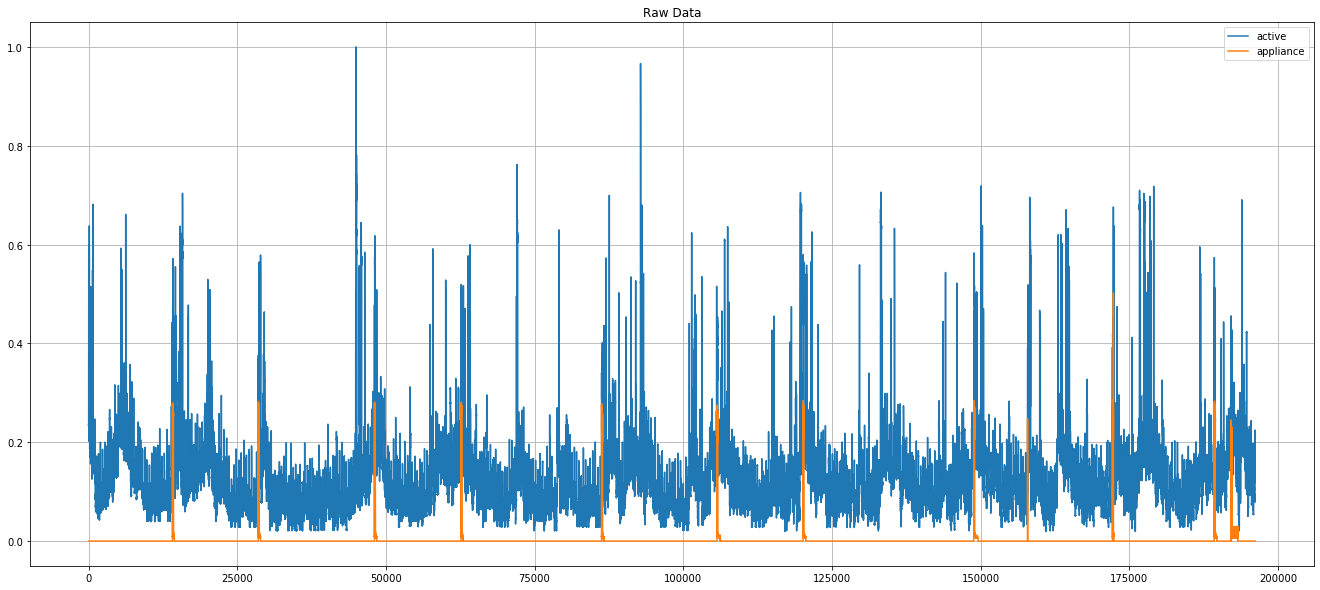

feature selection is done..
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100building tree 18 of 100

building tree 19 of 100
building tree 20 of 100building tree 21 of 100
building tree 22 of 100
building tree 23 of 100building tree 24 of 100

building tree 25 of 100


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.



building tree 26 of 100
building tree 27 of 100building tree 28 of 100

building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 6

[Parallel(n_jobs=32)]: Done  88 out of 100 | elapsed:  1.0min remaining:    8.3s
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  1.2min finished


model fit is done..
a9      0.372190
max     0.127335
diff    0.090025
min     0.076120
std     0.061715
a1      0.045563
a0      0.031437
a8      0.024528
q0      0.023705
q2      0.020272
q1      0.020268
f5      0.011186
a7      0.008514
f1      0.007614
f9      0.007020
a2      0.006591
a5      0.006558
f6      0.006466
a6      0.006368
f4      0.006264
f3      0.005776
a3      0.005398
f7      0.005159
f2      0.005148
f8      0.005078
a4      0.005065
f0      0.004367
mean    0.004270
dtype: float64


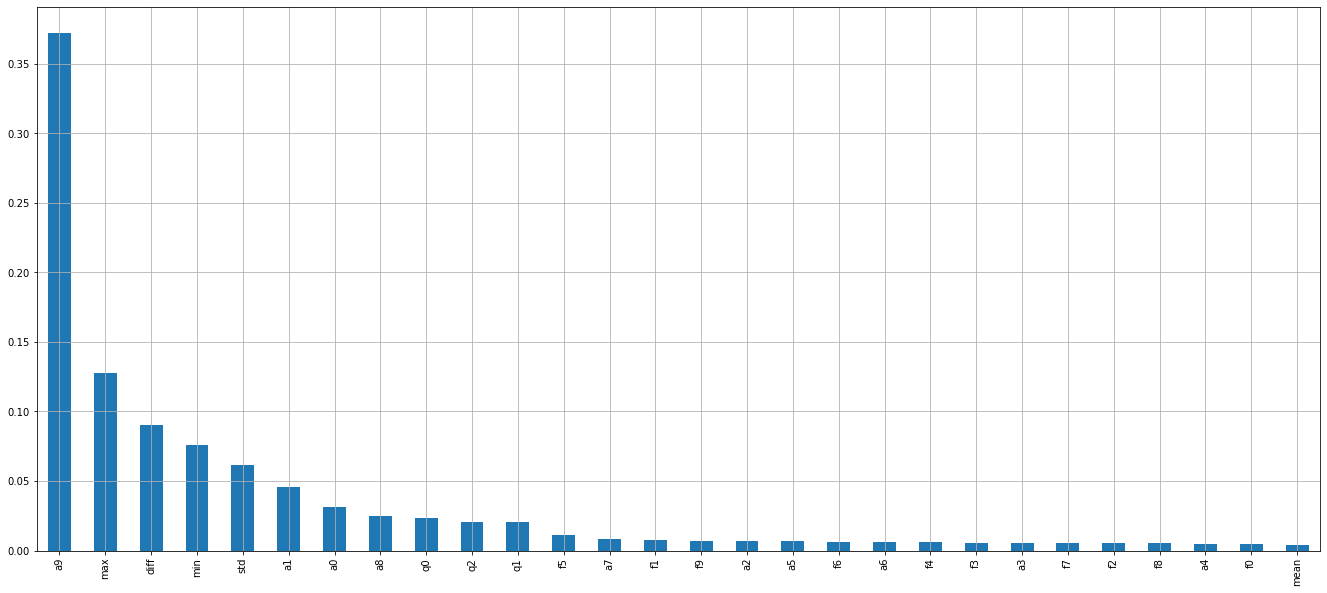

train on chunk is done..
Unix
2017-01-01 09:02:00+09:00    1.297323
2017-01-01 09:03:00+09:00    1.533427
2017-01-01 09:04:00+09:00    1.770283
2017-01-01 09:05:00+09:00    2.003699
2017-01-01 09:06:00+09:00    2.236144
                               ...   
2017-01-14 23:55:00+09:00    2.379764
2017-01-14 23:56:00+09:00    2.141978
2017-01-14 23:57:00+09:00    1.901856
2017-01-14 23:58:00+09:00    1.663856
2017-01-14 23:59:00+09:00    1.423277
Freq: 60S, Name: (power, active), Length: 19618, dtype: float64
total = 13, current = 1


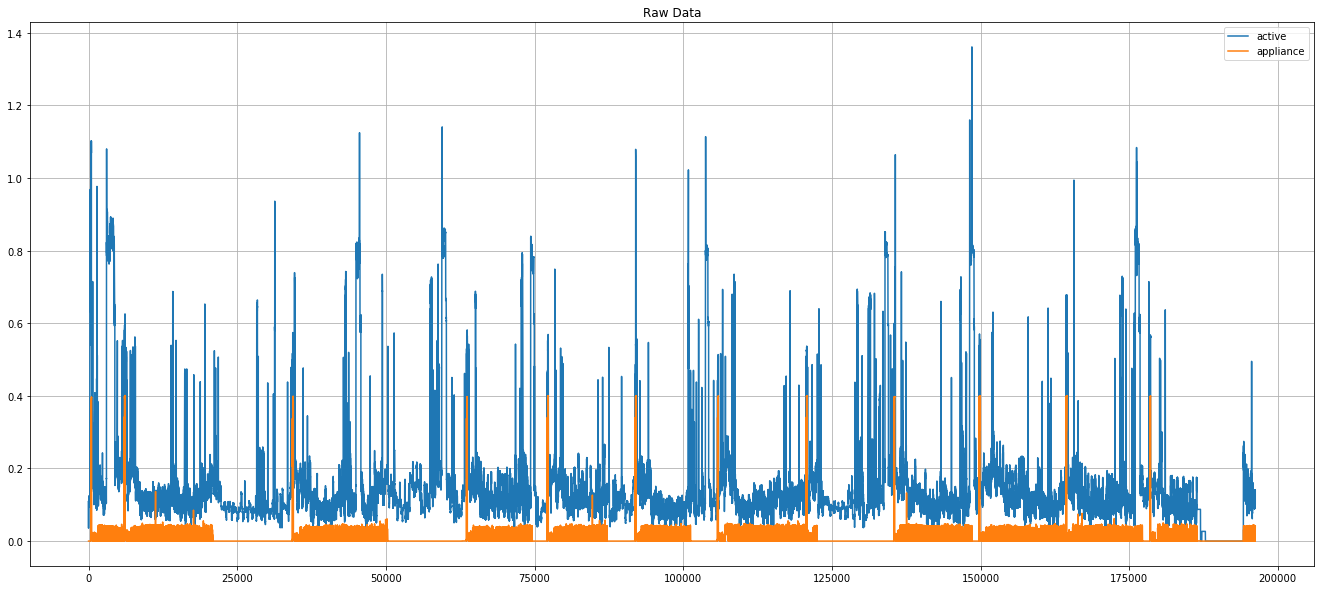

feature selection is done..
model fit is done..
a9      0.372190
max     0.127335
diff    0.090025
min     0.076120
std     0.061715
a1      0.045563
a0      0.031437
a8      0.024528
q0      0.023705
q2      0.020272
q1      0.020268
f5      0.011186
a7      0.008514
f1      0.007614
f9      0.007020
a2      0.006591
a5      0.006558
f6      0.006466
a6      0.006368
f4      0.006264
f3      0.005776
a3      0.005398
f7      0.005159
f2      0.005148
f8      0.005078
a4      0.005065
f0      0.004367
mean    0.004270
dtype: float64


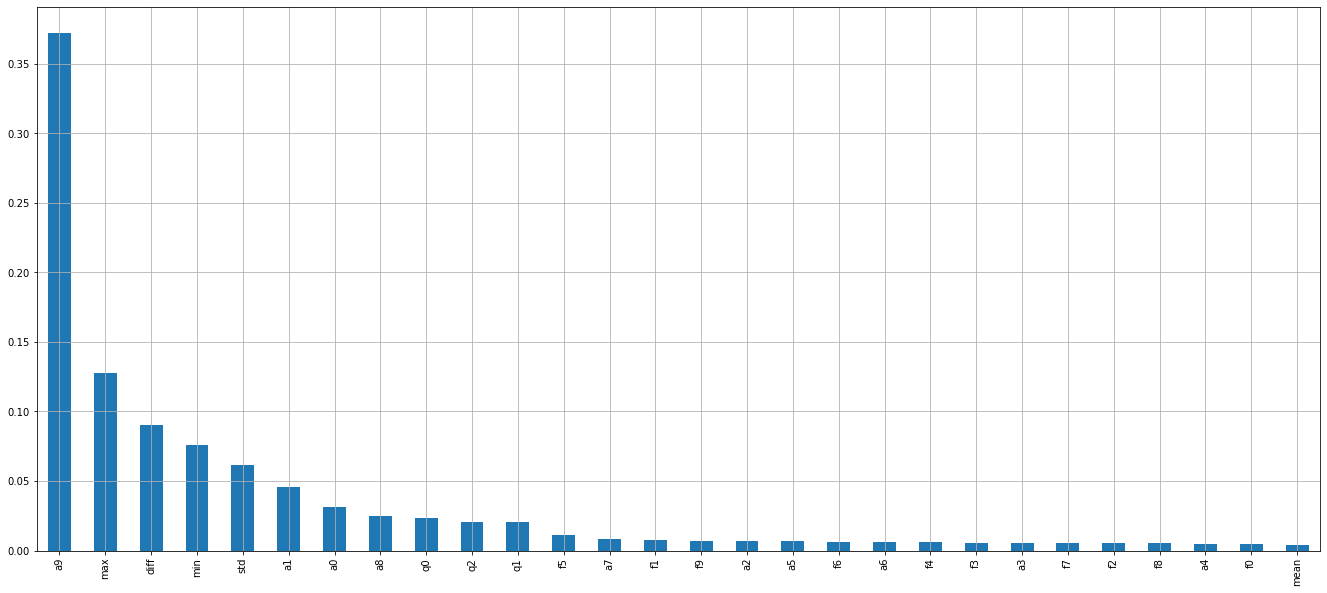

train on chunk is done..
Unix
2017-01-01 09:00:00+09:00      1.158210
2017-01-01 09:01:00+09:00      1.389641
2017-01-01 09:02:00+09:00      1.623118
2017-01-01 09:03:00+09:00      1.856685
2017-01-01 09:04:00+09:00      2.092601
                                ...    
2017-01-14 23:55:00+09:00    387.234089
2017-01-14 23:56:00+09:00    356.540225
2017-01-14 23:57:00+09:00    309.512834
2017-01-14 23:58:00+09:00    264.151345
2017-01-14 23:59:00+09:00    235.668189
Freq: 60S, Name: (power, active), Length: 19620, dtype: float64
total = 13, current = 2


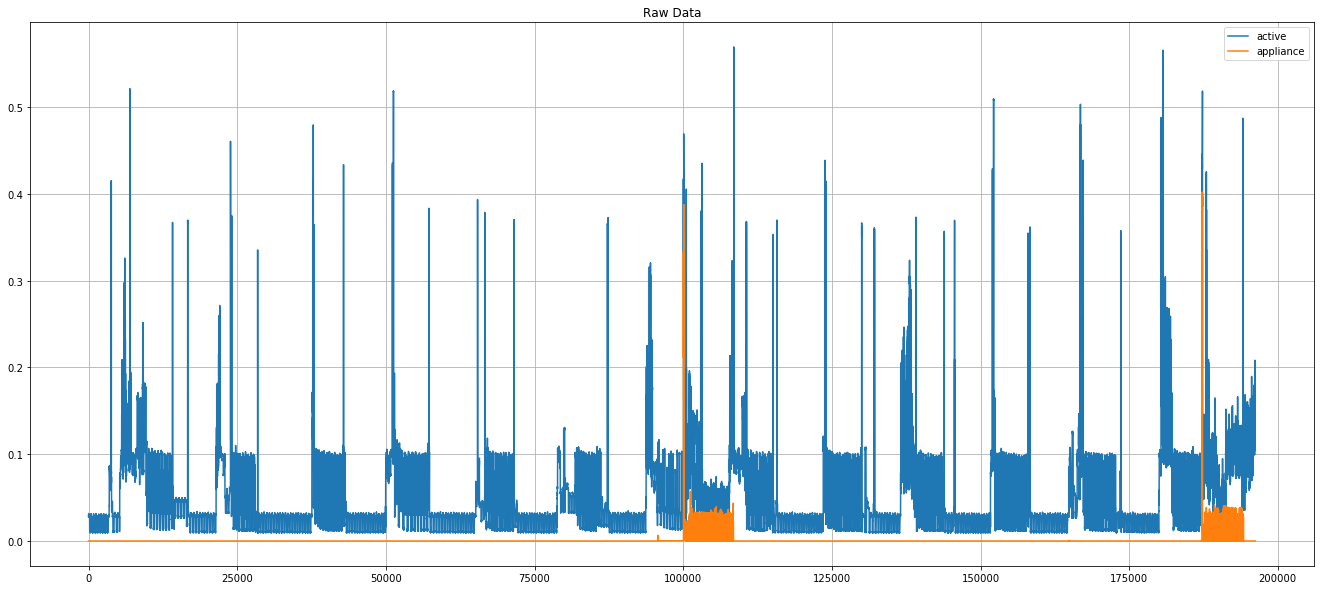

feature selection is done..
model fit is done..
a9      0.372190
max     0.127335
diff    0.090025
min     0.076120
std     0.061715
a1      0.045563
a0      0.031437
a8      0.024528
q0      0.023705
q2      0.020272
q1      0.020268
f5      0.011186
a7      0.008514
f1      0.007614
f9      0.007020
a2      0.006591
a5      0.006558
f6      0.006466
a6      0.006368
f4      0.006264
f3      0.005776
a3      0.005398
f7      0.005159
f2      0.005148
f8      0.005078
a4      0.005065
f0      0.004367
mean    0.004270
dtype: float64


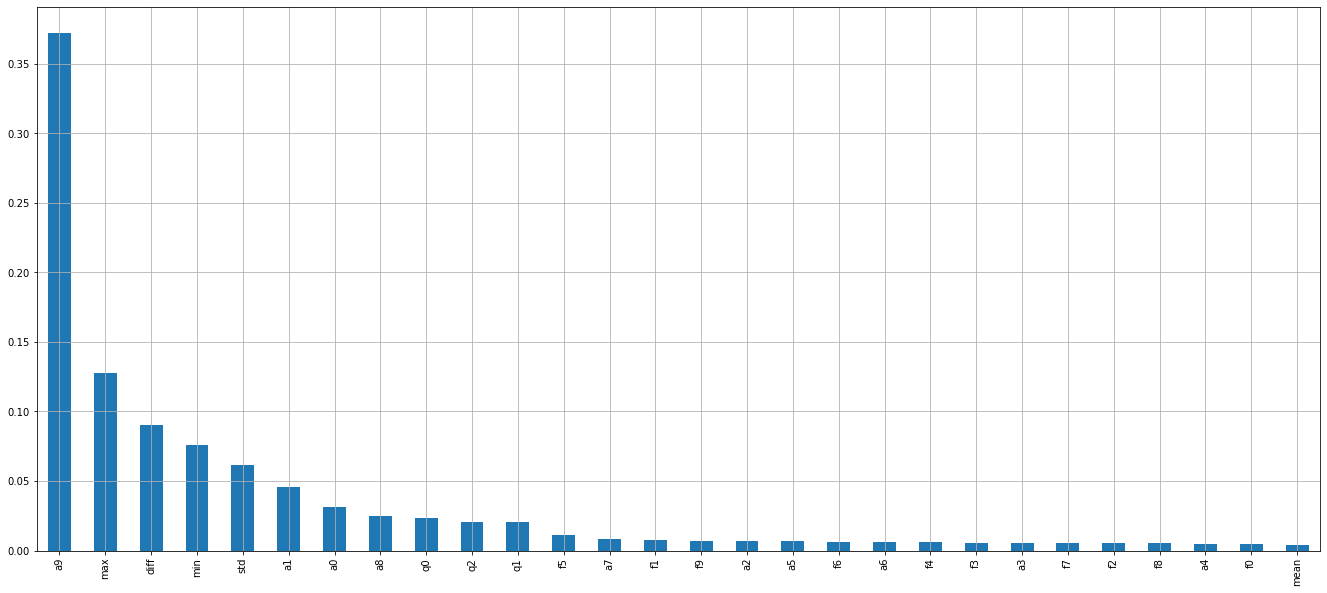

train on chunk is done..
Unix
2017-01-01 09:00:00+09:00    2.049003
2017-01-01 09:01:00+09:00    2.454395
2017-01-01 09:02:00+09:00    2.862009
2017-01-01 09:03:00+09:00    3.270509
2017-01-01 09:04:00+09:00    3.677809
                               ...   
2017-01-14 23:55:00+09:00    4.112392
2017-01-14 23:56:00+09:00    3.706426
2017-01-14 23:57:00+09:00    3.297703
2017-01-14 23:58:00+09:00    2.884116
2017-01-14 23:59:00+09:00    2.473494
Freq: 60S, Name: (power, active), Length: 19620, dtype: float64
total = 13, current = 3


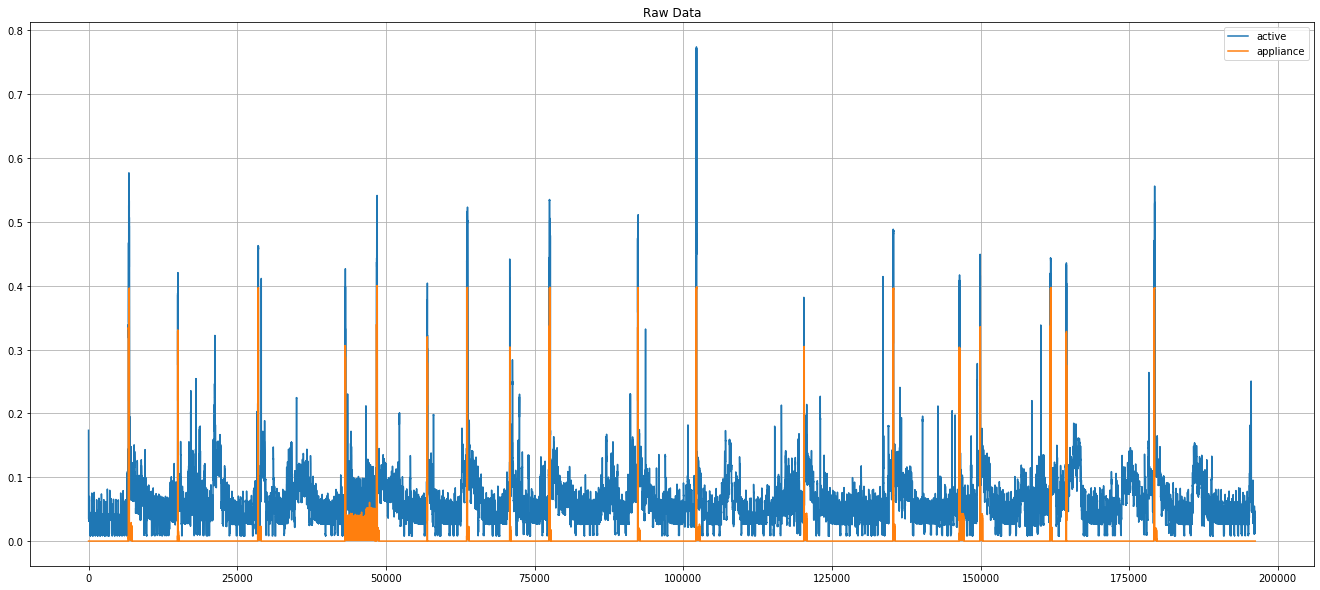

feature selection is done..
model fit is done..
a9      0.372190
max     0.127335
diff    0.090025
min     0.076120
std     0.061715
a1      0.045563
a0      0.031437
a8      0.024528
q0      0.023705
q2      0.020272
q1      0.020268
f5      0.011186
a7      0.008514
f1      0.007614
f9      0.007020
a2      0.006591
a5      0.006558
f6      0.006466
a6      0.006368
f4      0.006264
f3      0.005776
a3      0.005398
f7      0.005159
f2      0.005148
f8      0.005078
a4      0.005065
f0      0.004367
mean    0.004270
dtype: float64


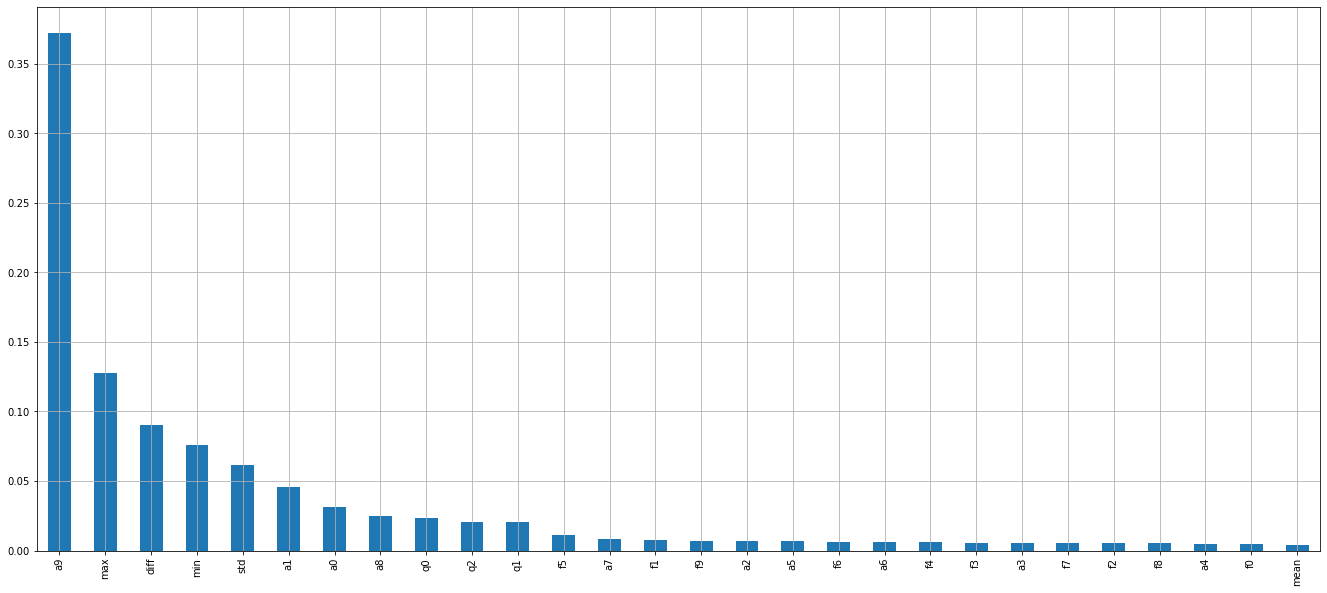

train on chunk is done..
Unix
2017-01-01 09:00:00+09:00    1.145064
2017-01-01 09:01:00+09:00    1.375529
2017-01-01 09:02:00+09:00    1.603051
2017-01-01 09:03:00+09:00    1.832729
2017-01-01 09:04:00+09:00    2.059874
                               ...   
2017-01-14 23:55:00+09:00    2.265894
2017-01-14 23:56:00+09:00    2.040032
2017-01-14 23:57:00+09:00    1.819110
2017-01-14 23:58:00+09:00    1.597007
2017-01-14 23:59:00+09:00    1.370959
Freq: 60S, Name: (power, active), Length: 19620, dtype: float64
total = 13, current = 4
total = 13, current = 5


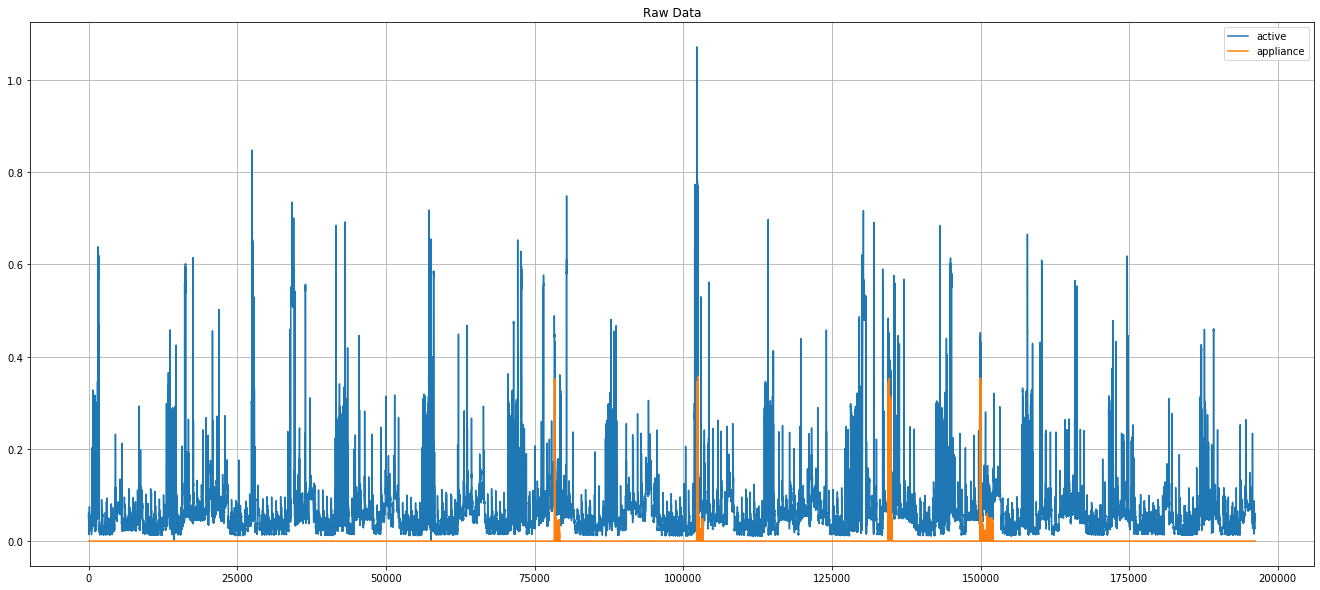

feature selection is done..
model fit is done..
a9      0.372190
max     0.127335
diff    0.090025
min     0.076120
std     0.061715
a1      0.045563
a0      0.031437
a8      0.024528
q0      0.023705
q2      0.020272
q1      0.020268
f5      0.011186
a7      0.008514
f1      0.007614
f9      0.007020
a2      0.006591
a5      0.006558
f6      0.006466
a6      0.006368
f4      0.006264
f3      0.005776
a3      0.005398
f7      0.005159
f2      0.005148
f8      0.005078
a4      0.005065
f0      0.004367
mean    0.004270
dtype: float64


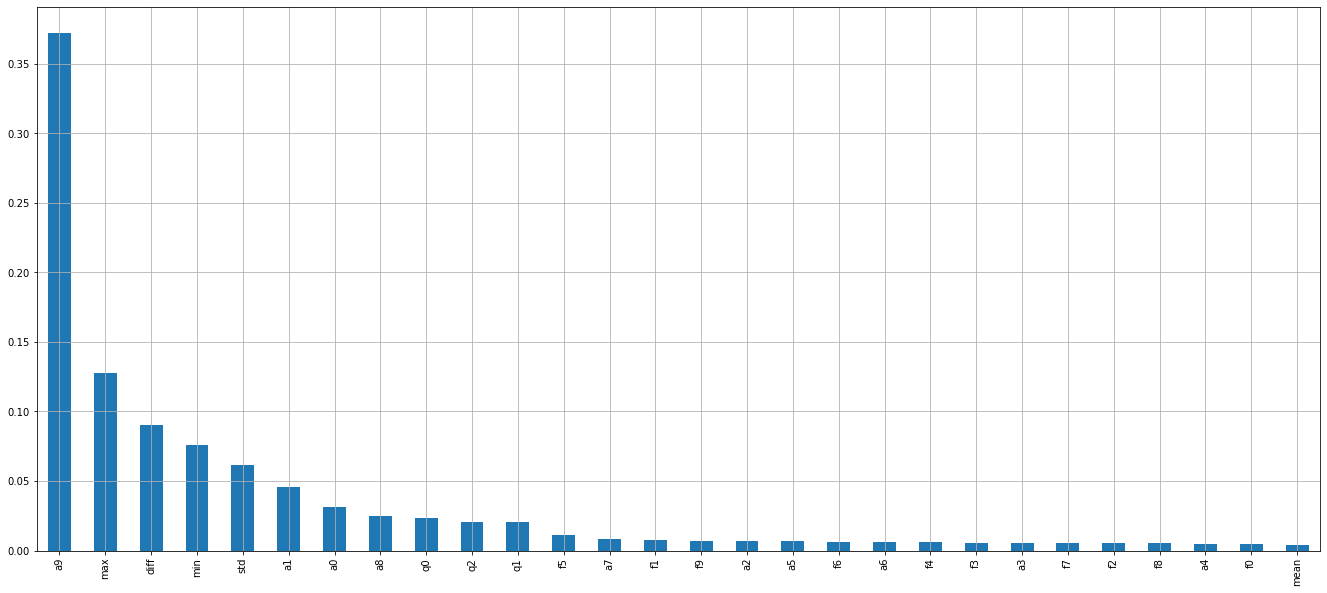

train on chunk is done..
Unix
2017-01-01 09:00:00+09:00    1.112814
2017-01-01 09:01:00+09:00    1.336350
2017-01-01 09:02:00+09:00    1.564027
2017-01-01 09:03:00+09:00    1.787072
2017-01-01 09:04:00+09:00    2.011274
                               ...   
2017-01-14 23:55:00+09:00    2.286809
2017-01-14 23:56:00+09:00    2.062849
2017-01-14 23:57:00+09:00    1.836272
2017-01-14 23:58:00+09:00    1.604649
2017-01-14 23:59:00+09:00    1.379561
Freq: 60S, Name: (power, active), Length: 19620, dtype: float64
total = 13, current = 6


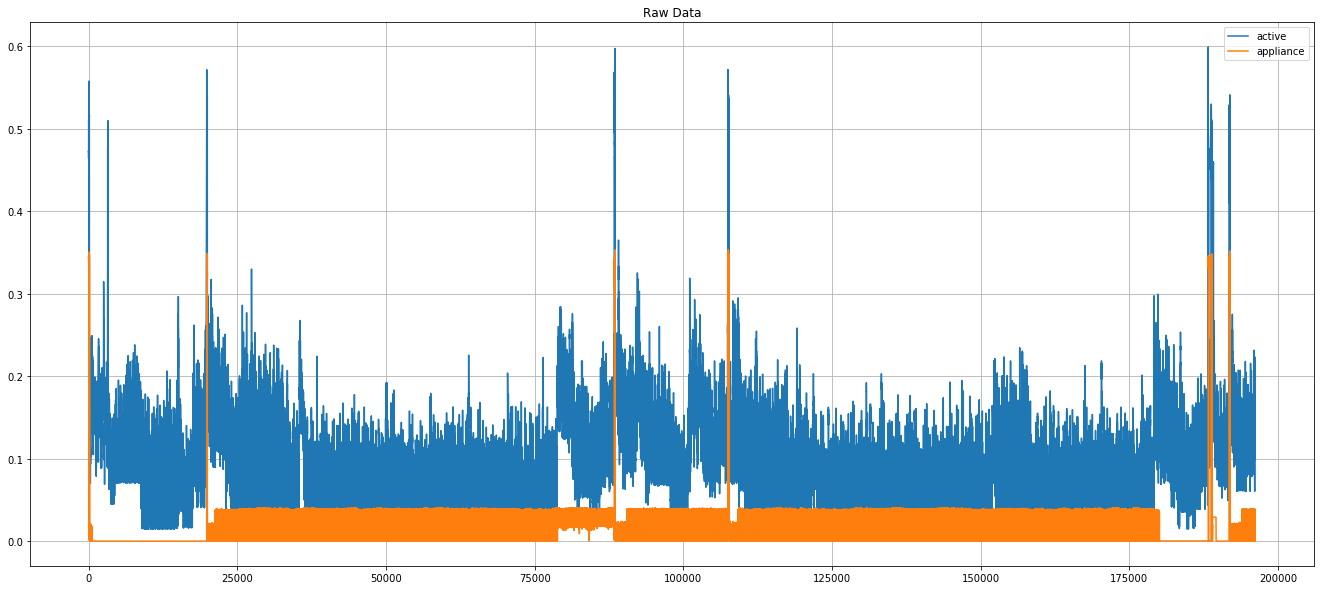

feature selection is done..
model fit is done..
a9      0.372190
max     0.127335
diff    0.090025
min     0.076120
std     0.061715
a1      0.045563
a0      0.031437
a8      0.024528
q0      0.023705
q2      0.020272
q1      0.020268
f5      0.011186
a7      0.008514
f1      0.007614
f9      0.007020
a2      0.006591
a5      0.006558
f6      0.006466
a6      0.006368
f4      0.006264
f3      0.005776
a3      0.005398
f7      0.005159
f2      0.005148
f8      0.005078
a4      0.005065
f0      0.004367
mean    0.004270
dtype: float64


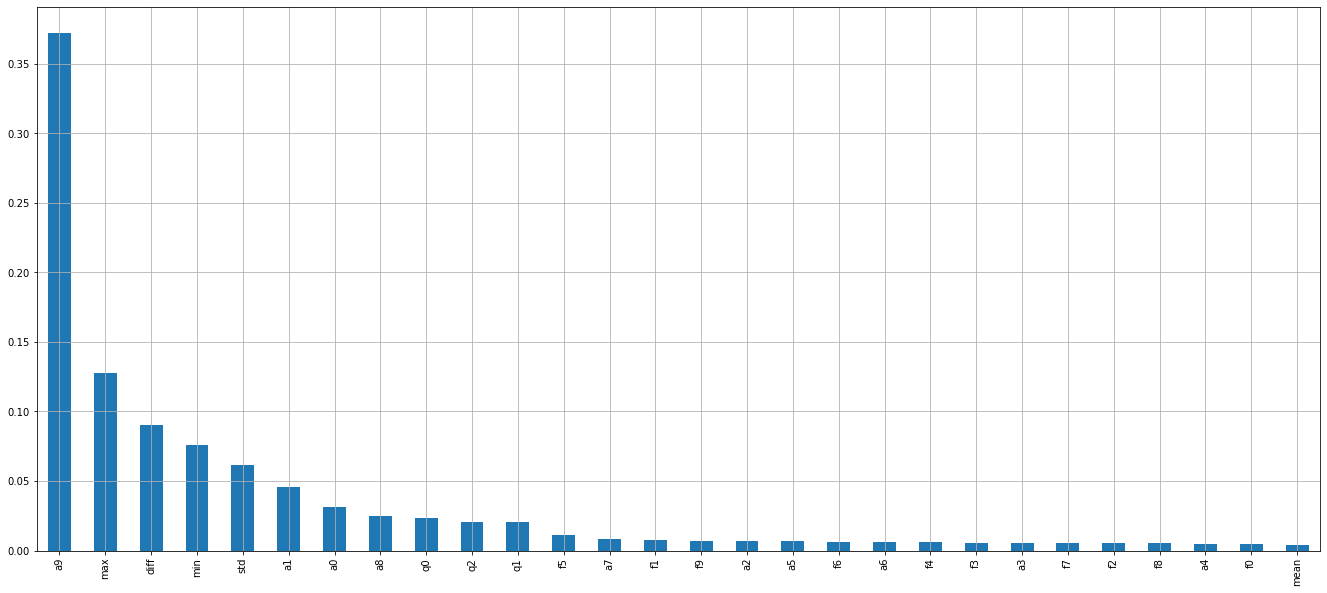

train on chunk is done..
Unix
2017-01-01 09:04:00+09:00     5988.970727
2017-01-01 09:05:00+09:00     7164.740760
2017-01-01 09:06:00+09:00     8320.987083
2017-01-01 09:07:00+09:00     9537.868484
2017-01-01 09:08:00+09:00    10751.189362
                                 ...     
2017-01-14 23:55:00+09:00      526.924722
2017-01-14 23:56:00+09:00      526.219749
2017-01-14 23:57:00+09:00      472.988294
2017-01-14 23:58:00+09:00      371.675772
2017-01-14 23:59:00+09:00      272.033705
Freq: 60S, Name: (power, active), Length: 19616, dtype: float64
total = 13, current = 7


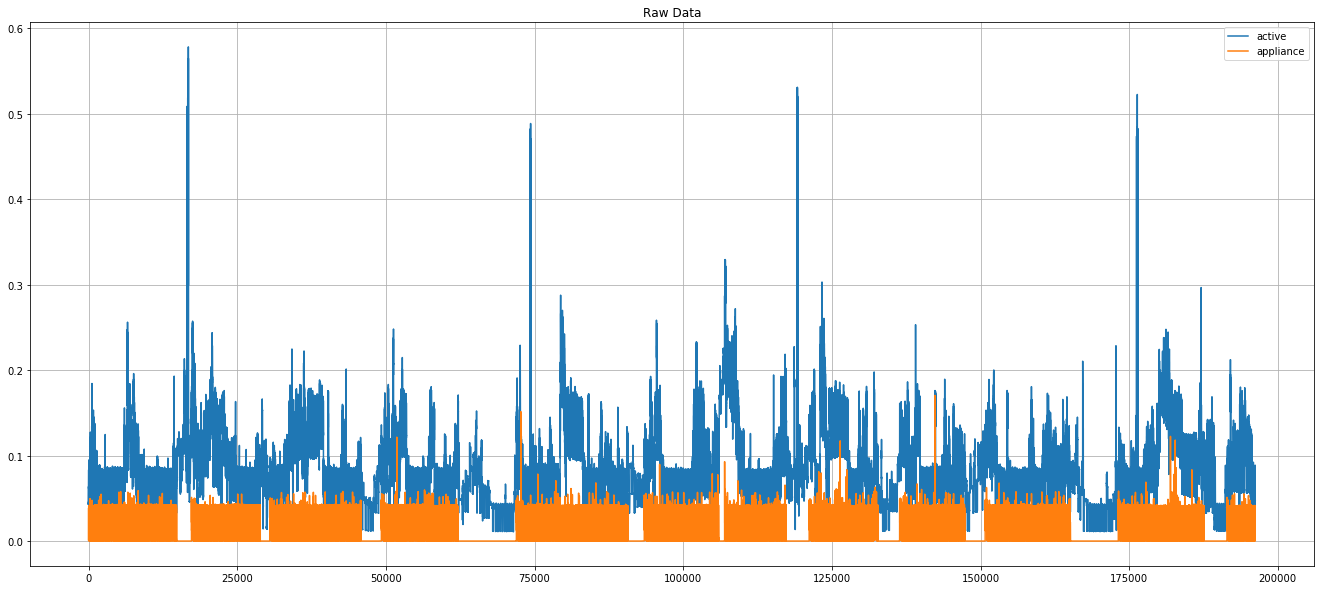

feature selection is done..
model fit is done..
a9      0.372190
max     0.127335
diff    0.090025
min     0.076120
std     0.061715
a1      0.045563
a0      0.031437
a8      0.024528
q0      0.023705
q2      0.020272
q1      0.020268
f5      0.011186
a7      0.008514
f1      0.007614
f9      0.007020
a2      0.006591
a5      0.006558
f6      0.006466
a6      0.006368
f4      0.006264
f3      0.005776
a3      0.005398
f7      0.005159
f2      0.005148
f8      0.005078
a4      0.005065
f0      0.004367
mean    0.004270
dtype: float64


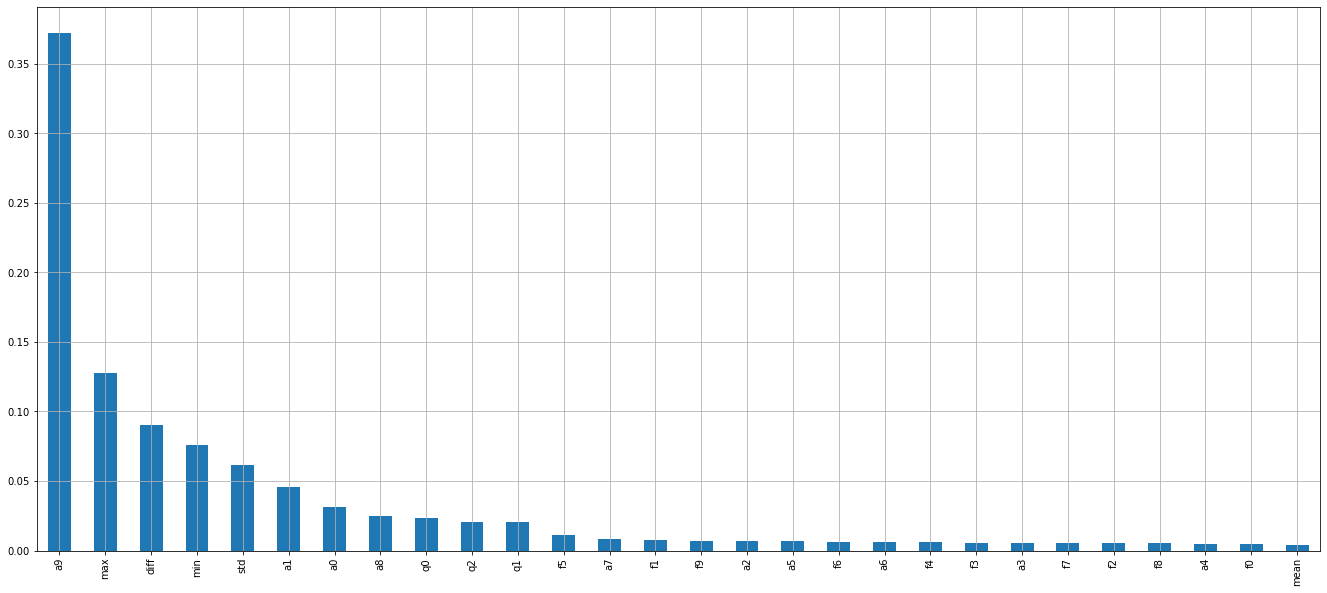

train on chunk is done..
Unix
2016-10-01 09:00:00+09:00    156.281815
2016-10-01 09:01:00+09:00    188.616137
2016-10-01 09:02:00+09:00    232.627883
2016-10-01 09:03:00+09:00    251.883405
2016-10-01 09:04:00+09:00    290.775935
                                ...    
2016-10-14 23:55:00+09:00    323.091961
2016-10-14 23:56:00+09:00    290.501628
2016-10-14 23:57:00+09:00    258.111283
2016-10-14 23:58:00+09:00    208.588027
2016-10-14 23:59:00+09:00    192.927326
Freq: 60S, Name: (power, active), Length: 19620, dtype: float64
total = 13, current = 8


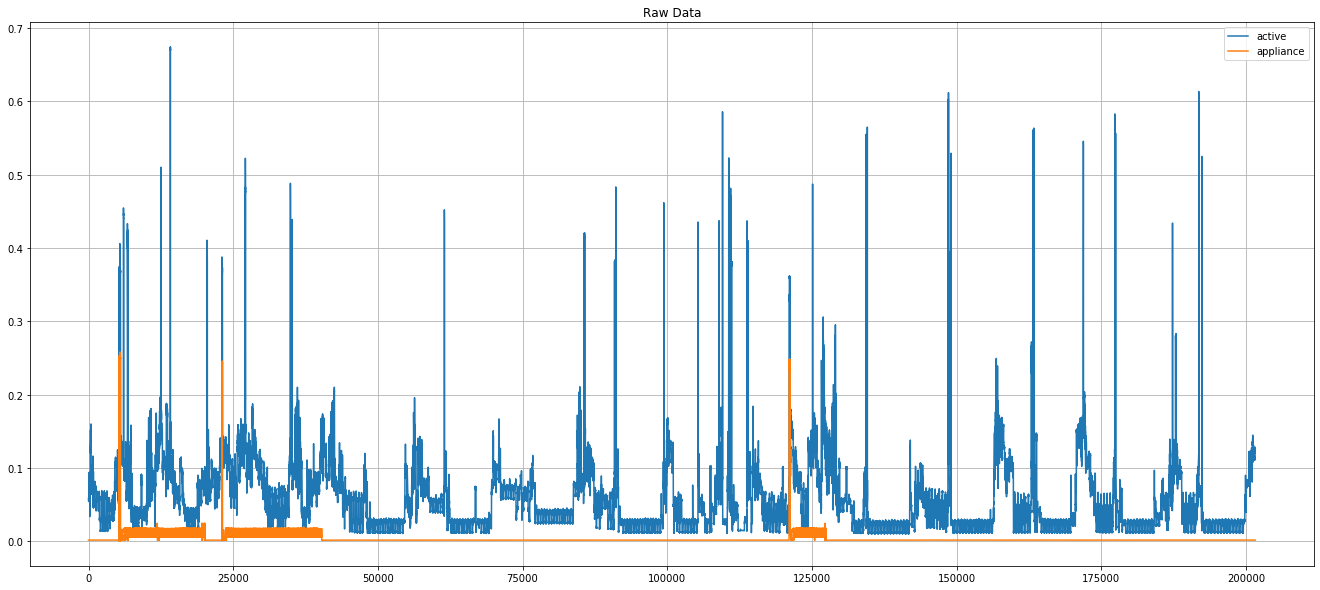

feature selection is done..
model fit is done..
a9      0.372190
max     0.127335
diff    0.090025
min     0.076120
std     0.061715
a1      0.045563
a0      0.031437
a8      0.024528
q0      0.023705
q2      0.020272
q1      0.020268
f5      0.011186
a7      0.008514
f1      0.007614
f9      0.007020
a2      0.006591
a5      0.006558
f6      0.006466
a6      0.006368
f4      0.006264
f3      0.005776
a3      0.005398
f7      0.005159
f2      0.005148
f8      0.005078
a4      0.005065
f0      0.004367
mean    0.004270
dtype: float64


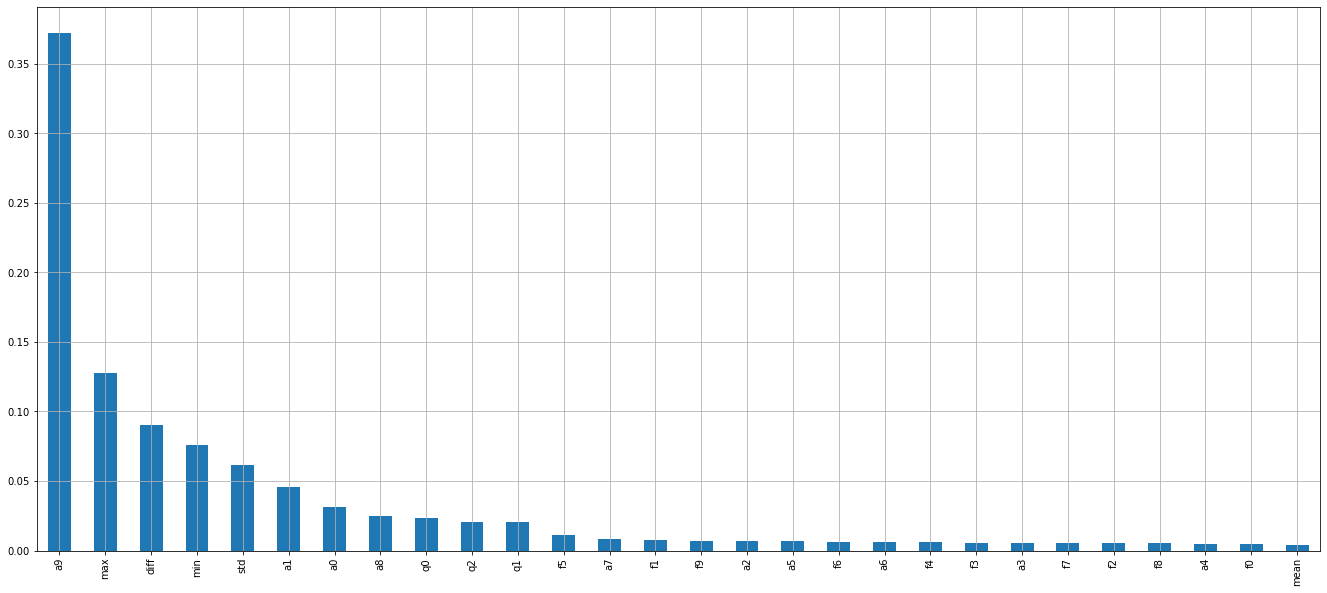

train on chunk is done..
Unix
2016-10-01 00:00:00+09:00    30.079043
2016-10-01 00:01:00+09:00    36.099066
2016-10-01 00:02:00+09:00    42.106321
2016-10-01 00:03:00+09:00    48.129410
2016-10-01 00:04:00+09:00    54.142799
                               ...    
2016-10-14 23:55:00+09:00    60.405096
2016-10-14 23:56:00+09:00    54.366507
2016-10-14 23:57:00+09:00    48.327885
2016-10-14 23:58:00+09:00    42.287173
2016-10-14 23:59:00+09:00    36.251867
Freq: 60S, Name: (power, active), Length: 20160, dtype: float64
total = 13, current = 9


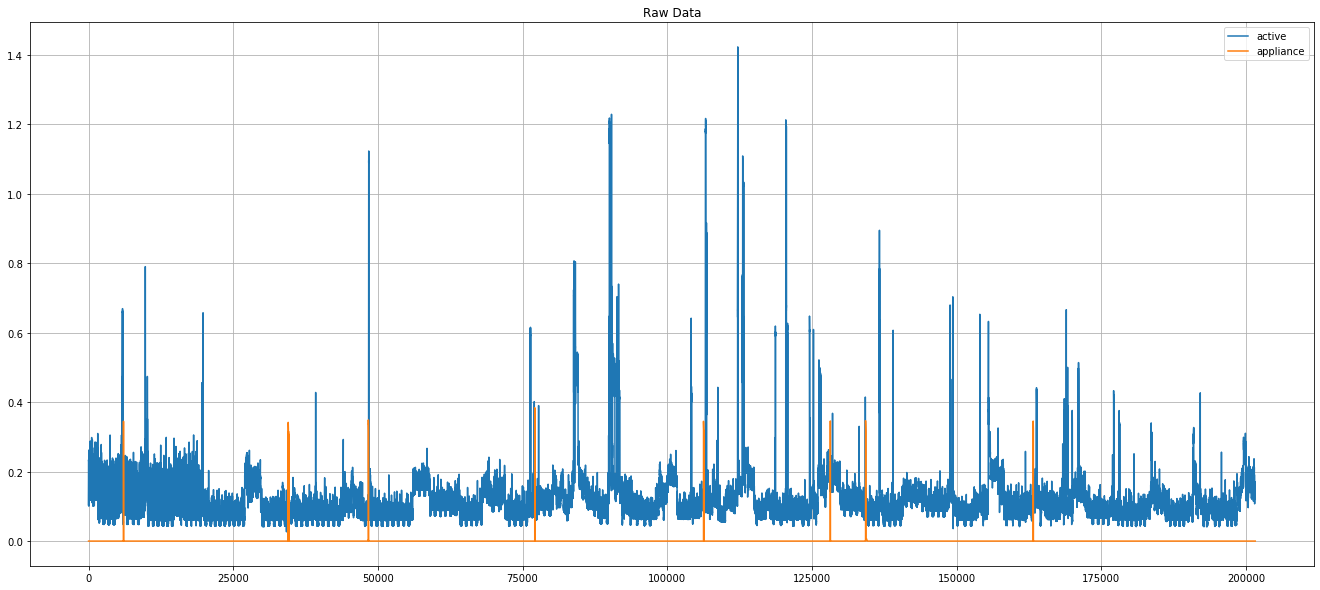

feature selection is done..
model fit is done..
a9      0.372190
max     0.127335
diff    0.090025
min     0.076120
std     0.061715
a1      0.045563
a0      0.031437
a8      0.024528
q0      0.023705
q2      0.020272
q1      0.020268
f5      0.011186
a7      0.008514
f1      0.007614
f9      0.007020
a2      0.006591
a5      0.006558
f6      0.006466
a6      0.006368
f4      0.006264
f3      0.005776
a3      0.005398
f7      0.005159
f2      0.005148
f8      0.005078
a4      0.005065
f0      0.004367
mean    0.004270
dtype: float64


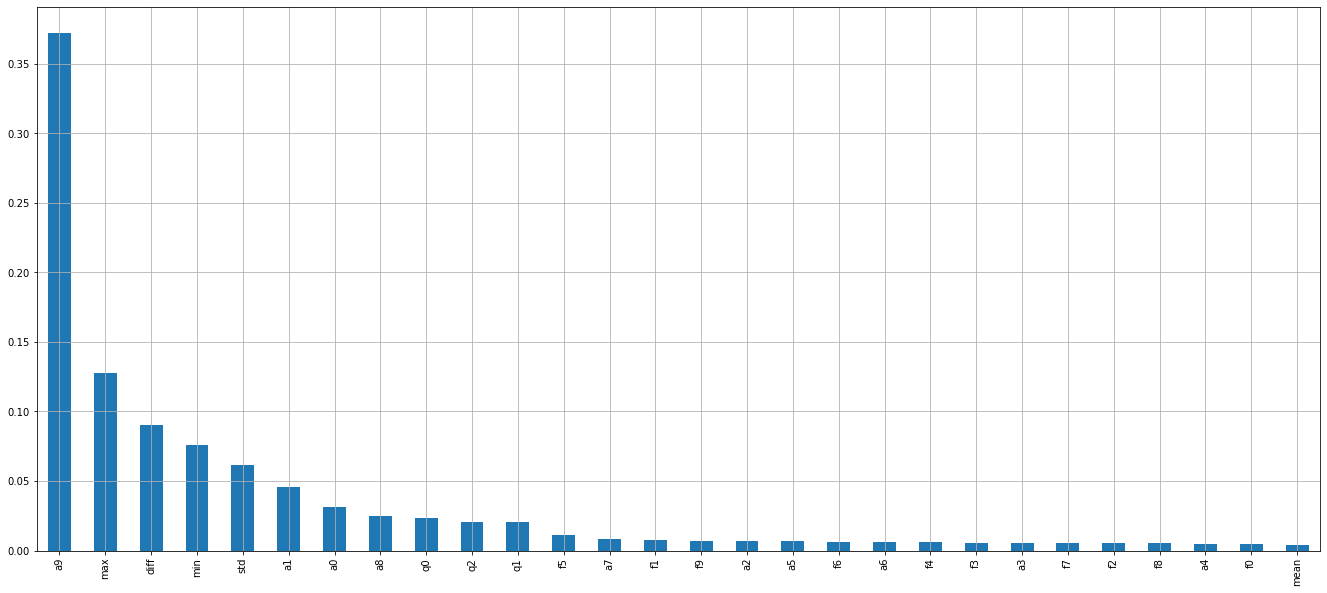

train on chunk is done..
Unix
2017-04-01 00:00:00+09:00    1.617573
2017-04-01 00:01:00+09:00    1.943855
2017-04-01 00:02:00+09:00    2.268411
2017-04-01 00:03:00+09:00    2.597577
2017-04-01 00:04:00+09:00    2.922738
                               ...   
2017-04-14 23:55:00+09:00    3.238040
2017-04-14 23:56:00+09:00    2.915940
2017-04-14 23:57:00+09:00    2.593351
2017-04-14 23:58:00+09:00    2.268729
2017-04-14 23:59:00+09:00    1.942922
Freq: 60S, Name: (power, active), Length: 20160, dtype: float64
total = 13, current = 10
total = 13, current = 11
total = 13, current = 12


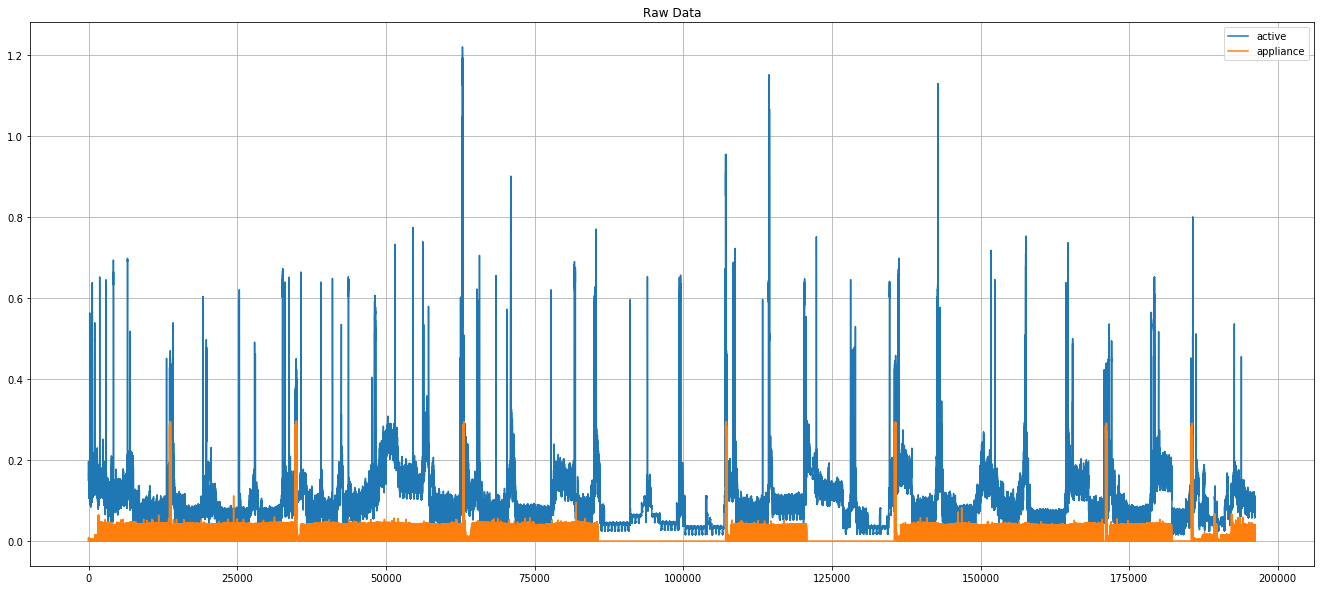

feature selection is done..
model fit is done..
a9      0.372190
max     0.127335
diff    0.090025
min     0.076120
std     0.061715
a1      0.045563
a0      0.031437
a8      0.024528
q0      0.023705
q2      0.020272
q1      0.020268
f5      0.011186
a7      0.008514
f1      0.007614
f9      0.007020
a2      0.006591
a5      0.006558
f6      0.006466
a6      0.006368
f4      0.006264
f3      0.005776
a3      0.005398
f7      0.005159
f2      0.005148
f8      0.005078
a4      0.005065
f0      0.004367
mean    0.004270
dtype: float64


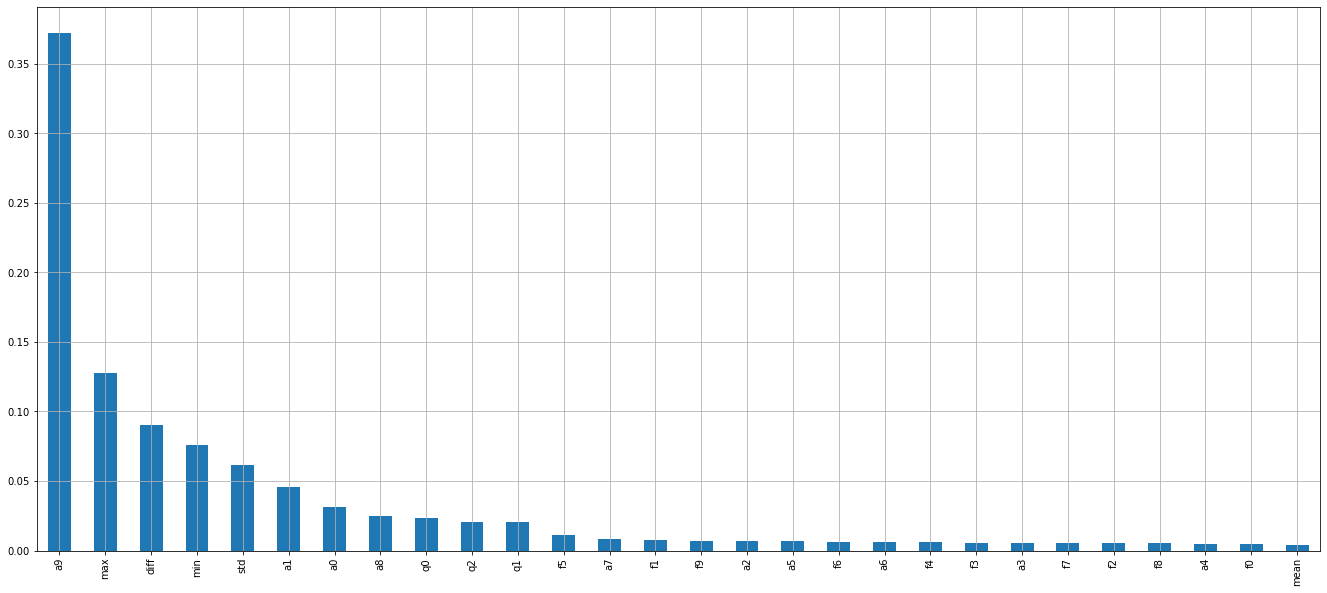

train on chunk is done..
Unix
2017-04-01 09:00:00+09:00     45.966254
2017-04-01 09:01:00+09:00     53.515481
2017-04-01 09:02:00+09:00     61.558071
2017-04-01 09:03:00+09:00     67.667093
2017-04-01 09:04:00+09:00     75.503756
                                ...    
2017-04-14 23:55:00+09:00    341.905147
2017-04-14 23:56:00+09:00    322.271769
2017-04-14 23:57:00+09:00    280.806436
2017-04-14 23:58:00+09:00    242.905942
2017-04-14 23:59:00+09:00    207.427908
Freq: 60S, Name: (power, active), Length: 19620, dtype: float64
total = 13, current = 13
elapsed time (secs) = 1362.4646060466766


In [13]:
dataset = DataSet(DATA_FILE)

# pre-trained model
#model = DTDisaggregator(algorithm='DRF', use_feature=True, reactive=False)
model = DTDisaggregator(algorithm='DRF', use_feature=True, reactive=False)

start = time.time()

activations = []

count = 0

for part in test_plan:

    if part['train'] == True:
        dataset.set_window(start=part['sdate'], end=part['edate'])

        train_elec = dataset.buildings[part['home_id']].elec
        train_mains = train_elec.all_meters()[0]
        train_meter = train_elec.submeters()[target_appliance]

        #if count > 0:
        #model.add_trees()
        model.train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)

        a_list = extract_activation(part['home_id'], get_series_data(train_meter,TRAIN_SAMPLE_PERIOD*ROLL_WINDOW_SIZE),LEAST_AMOUNT,MIN_WIDTH,MAX_WIDTH,MIN_HEIGHT,MAX_HEIGHT)
        #activations = activations + a_list
        activations.append(a_list)

    count = count + 1        
    print('total = ' + str(len(test_plan)) + ', current = ' + str(count))

end = time.time()            
print("elapsed time (secs) = " + str(end-start))

### Export model

In [14]:
model.export_model('work/out/' + target_appliance.replace(' ','_') + '.h5')
mmax = model.mmax
print(model.mmax)

3535.581222222222


### Domain Information

No handles with labels found to put in legend.


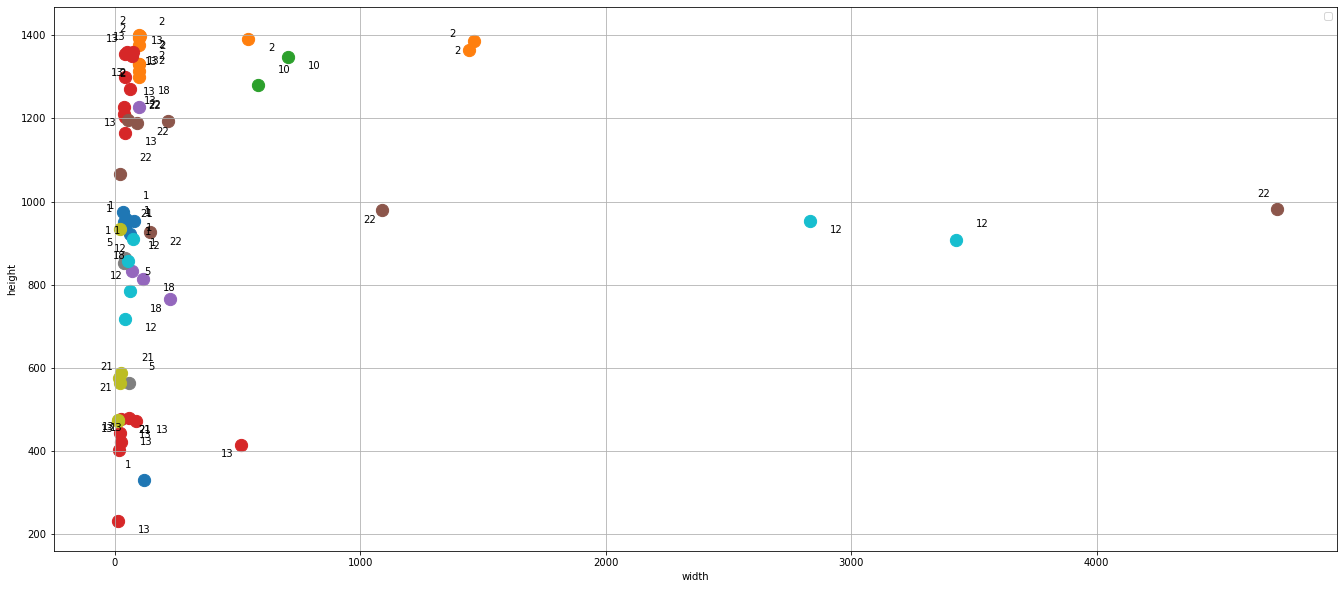

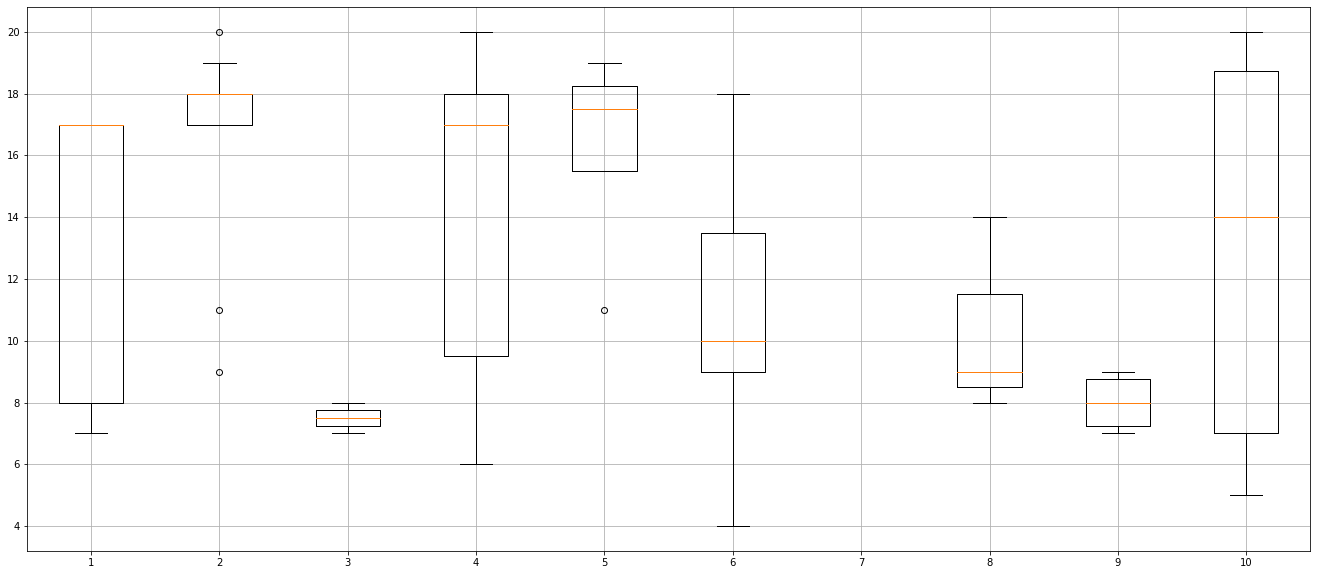

w_min = 13
w_max = 1464
h_min = 330
h_max = 1400


In [15]:
if PROFILING == True:
    
    scatter_activations(activations)
    plot_activation_time(activations)

    #### filtering conditions
    w_list = []
    h_list = []
    r_list = []

    for i in range(len(activations)):

        for j in range(len(activations[i])):

            w = activations[i][j]['width']
            h = activations[i][j]['height']
            r = h / w

            w_list.append(w)
            h_list.append(h)
            r_list.append(r)

    w_normal = exclude_anomalies(w_list, 2)
    h_normal = exclude_anomalies(h_list, 2)

    w_min = min(w_normal)
    w_max = max(w_normal)
    h_min = min(h_normal)
    h_max = max(h_normal)

    print('w_min = ' + str(w_min))
    print('w_max = ' + str(w_max))
    print('h_min = ' + str(h_min))
    print('h_max = ' + str(h_max))

    # reassign parameter
    MIN_WIDTH = w_min
    MAX_WIDTH = w_max
    MIN_HEIGHT = h_min

### Evaluation

New sensible chunk: 196198
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  88 out of 100 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.4s finished


Disaggregation is done..
============ Relative error in total energy: 0.8908639578928684
============ Mean absolute error(in Watts): 27.881137153683156
============ Recall: 0.0229024157935752
============ Precision: 0.7626874279123415
============ Accuracy: 0.4206464897705379
============ F1 Score: 0.04446947662200104


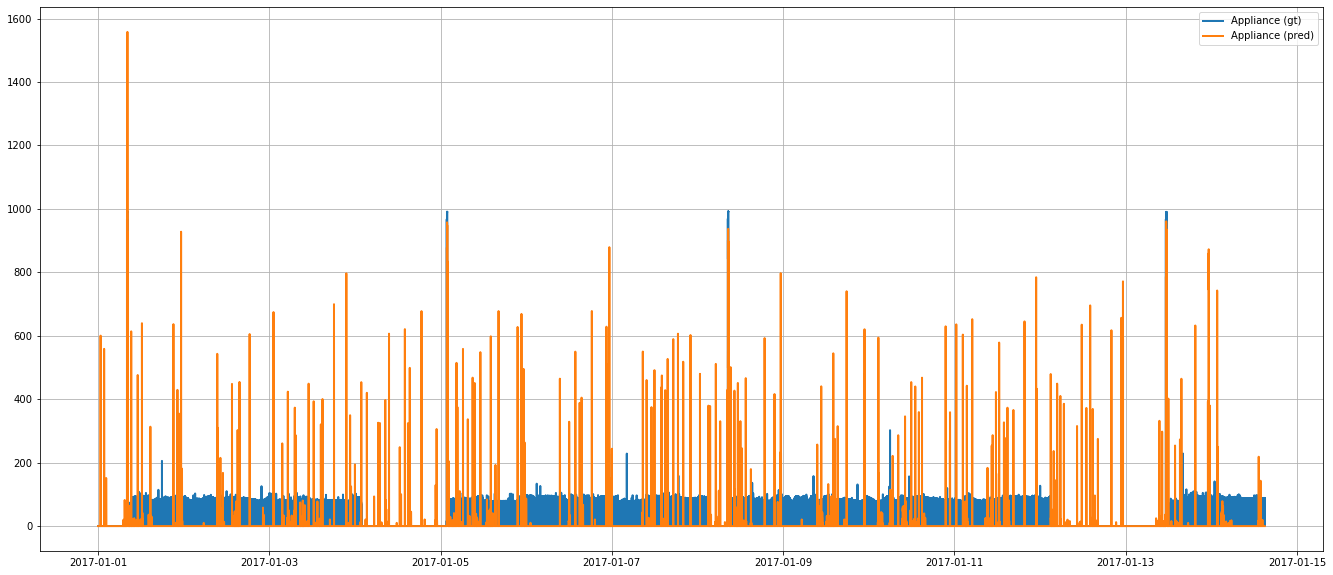

Unix
2017-01-01 09:00:00+09:00    1.169986
2017-01-01 09:01:00+09:00    1.404657
2017-01-01 09:02:00+09:00    1.638859
2017-01-01 09:03:00+09:00    1.873575
2017-01-01 09:04:00+09:00    2.107541
                               ...   
2017-01-14 23:55:00+09:00    5.639841
2017-01-14 23:56:00+09:00    5.276478
2017-01-14 23:57:00+09:00    4.950274
2017-01-14 23:58:00+09:00    4.589282
2017-01-14 23:59:00+09:00    4.263841
Freq: 60S, Name: (power, active), Length: 19620, dtype: float64
# of activations = 4
{'home_id': 14, 'start_idx': '2017-01-01 17:03:00', 'end_idx': '2017-01-01 17:28:00', 'width': 25, 'height': 537}
len=250, cnt=143
{'home_id': 14, 'start_idx': '2017-01-05 10:40:00', 'end_idx': '2017-01-05 11:07:00', 'width': 27, 'height': 562}
len=270, cnt=146
{'home_id': 14, 'start_idx': '2017-01-08 17:27:00', 'end_idx': '2017-01-08 17:53:00', 'width': 26, 'height': 516}
len=260, cnt=140
{'home_id': 14, 'start_idx': '2017-01-13 20:13:00', 'end_idx': '2017-01-13 20:37:00', 'width': 24, 

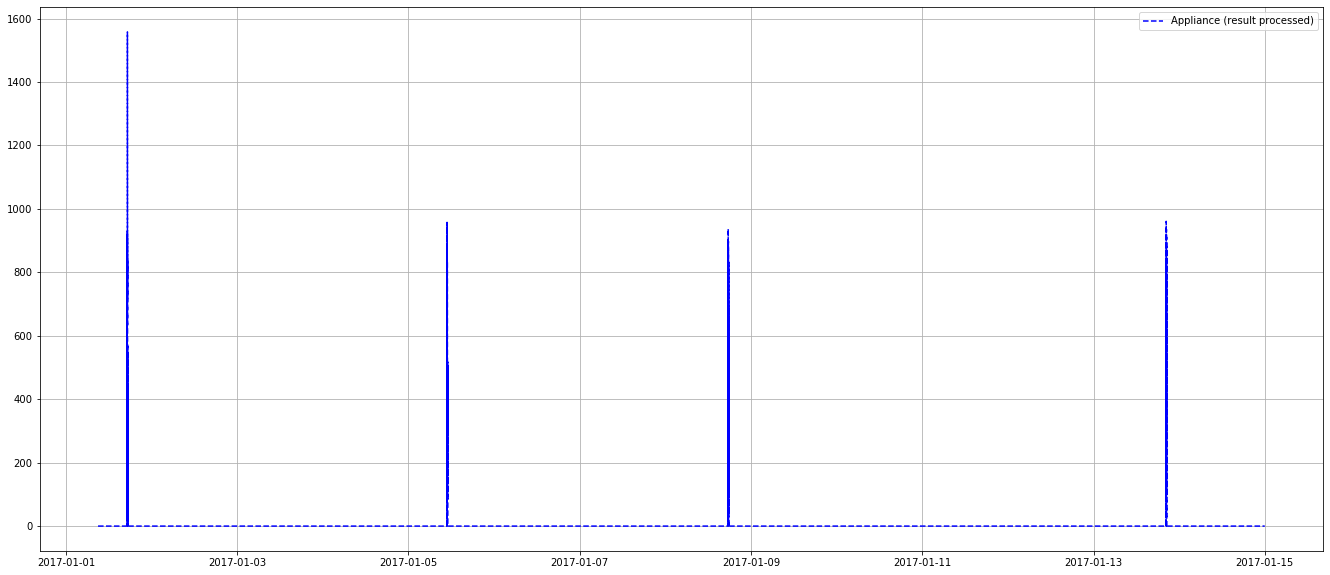

New sensible chunk: 201600
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  88 out of 100 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.6s finished


Disaggregation is done..
============ Relative error in total energy: 0.6994185779943233
============ Mean absolute error(in Watts): 39.02746971975718
============ Recall: 0.06298589790289848
============ Precision: 0.5076329474920316
============ Accuracy: 0.5242906746031746
============ F1 Score: 0.11206681048450566


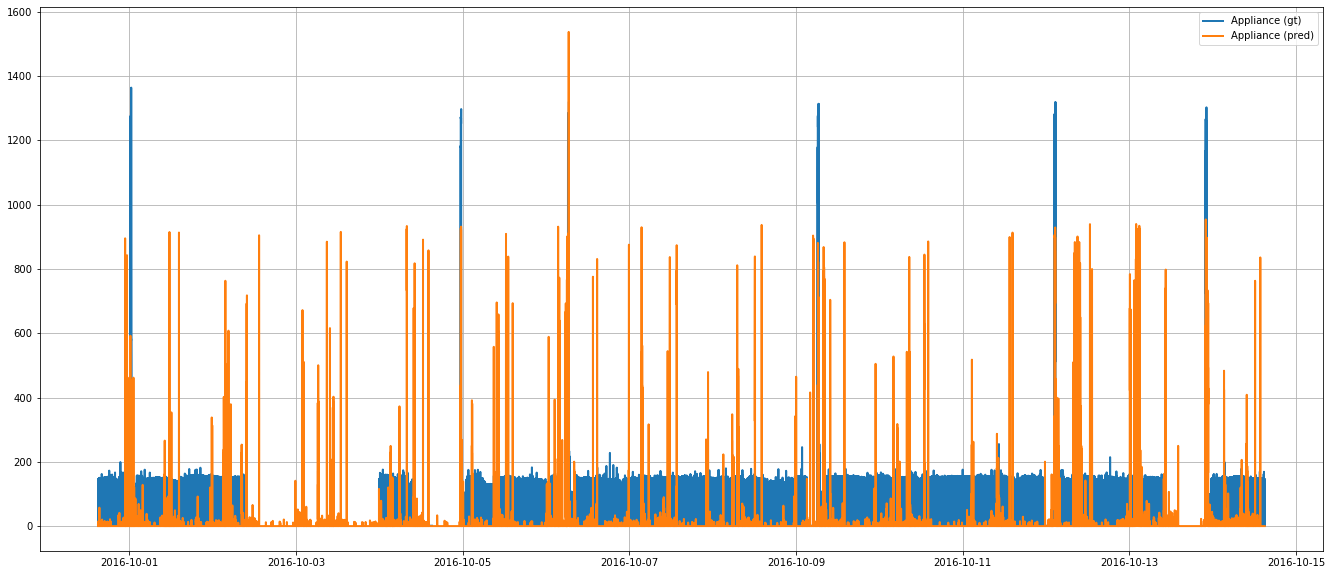

Unix
2016-10-01 00:00:00+09:00     7.299149
2016-10-01 00:01:00+09:00     8.709724
2016-10-01 00:02:00+09:00    14.913002
2016-10-01 00:03:00+09:00    20.835916
2016-10-01 00:04:00+09:00    22.935636
                               ...    
2016-10-14 23:55:00+09:00     3.719038
2016-10-14 23:56:00+09:00     3.484869
2016-10-14 23:57:00+09:00     3.250321
2016-10-14 23:58:00+09:00     3.017603
2016-10-14 23:59:00+09:00     2.783397
Freq: 60S, Name: (power, active), Length: 20160, dtype: float64
# of activations = 7
{'home_id': 6, 'start_idx': '2016-10-05 08:19:00', 'end_idx': '2016-10-05 08:48:00', 'width': 29, 'height': 349}
len=290, cnt=116
{'home_id': 6, 'start_idx': '2016-10-06 15:16:00', 'end_idx': '2016-10-06 15:42:00', 'width': 26, 'height': 648}
len=260, cnt=184
{'home_id': 6, 'start_idx': '2016-10-09 15:10:00', 'end_idx': '2016-10-09 15:43:00', 'width': 33, 'height': 368}
len=330, cnt=191
{'home_id': 6, 'start_idx': '2016-10-09 16:52:00', 'end_idx': '2016-10-09 17:26:00', 'width

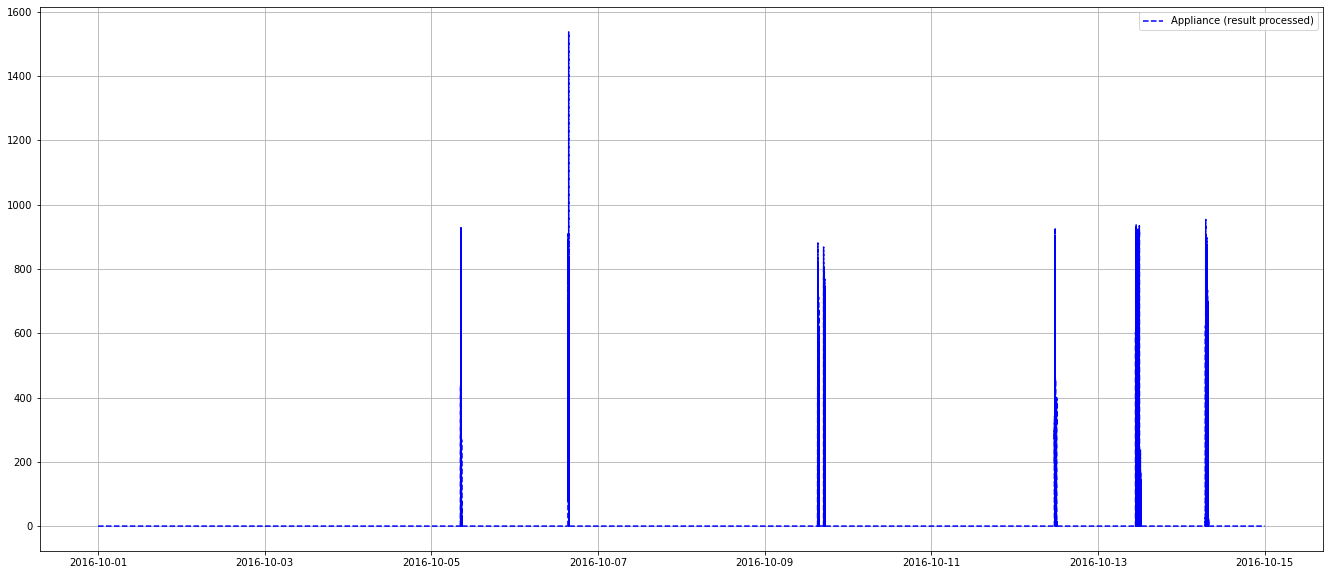

New sensible chunk: 196199
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  88 out of 100 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.4s finished


Disaggregation is done..
============ Relative error in total energy: 0.33158711729465634
============ Mean absolute error(in Watts): 6.92509943762284
============ Recall: 0.288854351687389
============ Precision: 0.0931948424068768
============ Accuracy: 0.9191535125051605
============ F1 Score: 0.14092287694974004


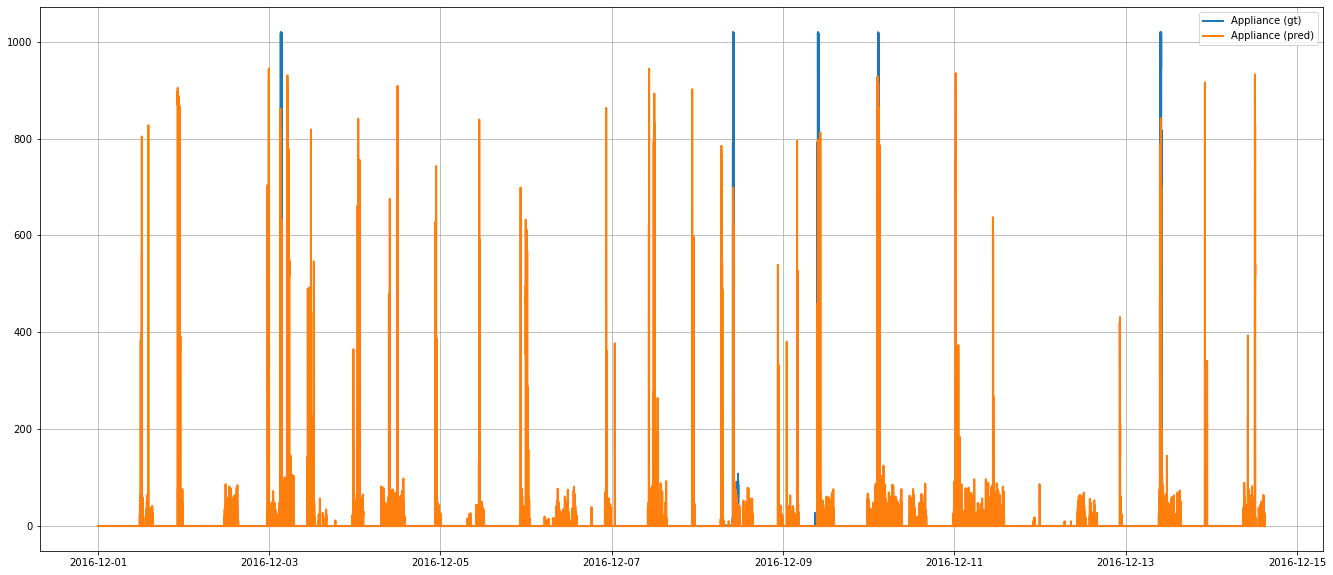

Unix
2016-12-01 09:00:00+09:00    54.555028
2016-12-01 09:01:00+09:00    54.788378
2016-12-01 09:02:00+09:00    55.021572
2016-12-01 09:03:00+09:00    55.255217
2016-12-01 09:04:00+09:00    55.487681
                               ...    
2016-12-14 23:55:00+09:00    54.495125
2016-12-14 23:56:00+09:00    50.048141
2016-12-14 23:57:00+09:00    46.580572
2016-12-14 23:58:00+09:00    41.752143
2016-12-14 23:59:00+09:00    39.419236
Freq: 60S, Name: (power, active), Length: 19620, dtype: float64
# of activations = 7
{'home_id': 9, 'start_idx': '2016-12-03 12:02:00', 'end_idx': '2016-12-03 12:37:00', 'width': 35, 'height': 368}
len=350, cnt=200
{'home_id': 9, 'start_idx': '2016-12-03 14:02:00', 'end_idx': '2016-12-03 14:43:00', 'width': 41, 'height': 358}
len=410, cnt=0
{'home_id': 9, 'start_idx': '2016-12-08 18:55:00', 'end_idx': '2016-12-08 19:21:00', 'width': 26, 'height': 375}
len=260, cnt=180
{'home_id': 9, 'start_idx': '2016-12-09 18:34:00', 'end_idx': '2016-12-09 19:07:00', 'width':

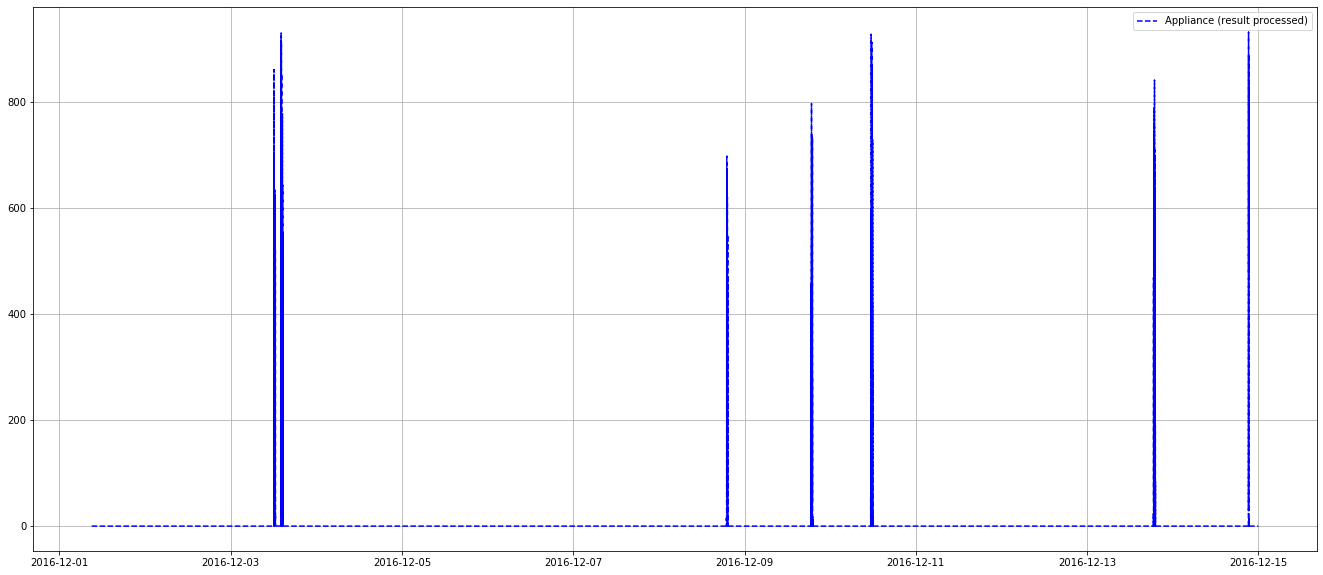

In [16]:
for part in test_plan:
    if part['train'] == False:
        disaggregate(dataset, model, part['home_id'], target_appliance, part['sdate'], part['edate'], True)

### Additional Test

In [17]:
pretrained_model = DTDisaggregator(algorithm='DRF', use_feature=True, reactive=False)
pretrained_model.import_model('work/out/' + target_appliance.replace(' ','_') + '.h5')
pretrained_model.mmax = mmax

New sensible chunk: 18000
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  88 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished


Disaggregation is done..
============ Relative error in total energy: 0.21040491650794566
============ Mean absolute error(in Watts): 6.808362928476868
============ Recall: 0.4282477341389728
============ Precision: 0.661610268378063
============ Accuracy: 0.9418333333333333
============ F1 Score: 0.5199449793672627


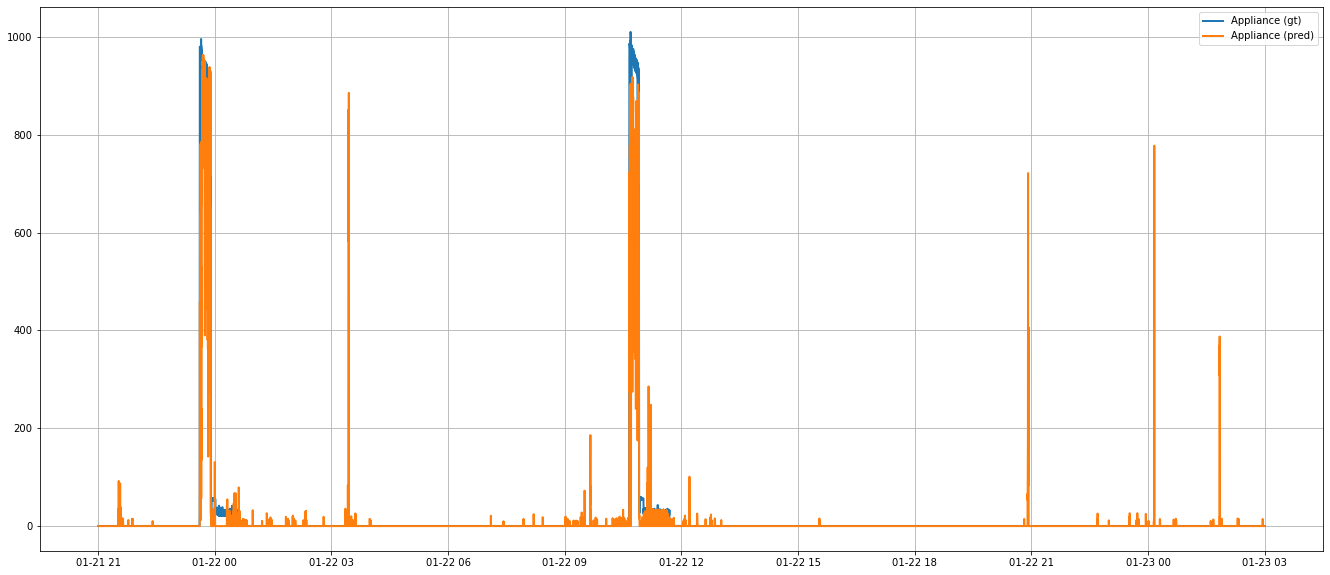

Unix
2017-01-22 06:00:00+09:00    1.240829
2017-01-22 06:01:00+09:00    1.474500
2017-01-22 06:02:00+09:00    1.708317
2017-01-22 06:03:00+09:00    1.942080
2017-01-22 06:04:00+09:00    2.865812
                               ...   
2017-01-23 11:55:00+09:00    7.663375
2017-01-23 11:56:00+09:00    6.921951
2017-01-23 11:57:00+09:00    6.302158
2017-01-23 11:58:00+09:00    5.767320
2017-01-23 11:59:00+09:00    5.448948
Freq: 60S, Name: (power, active), Length: 1800, dtype: float64
# of activations = 2
{'home_id': 1, 'start_idx': '2017-01-22 08:33:00', 'end_idx': '2017-01-22 08:59:00', 'width': 26, 'height': 793}
len=260, cnt=165
{'home_id': 1, 'start_idx': '2017-01-22 19:35:00', 'end_idx': '2017-01-22 20:00:00', 'width': 25, 'height': 677}
len=250, cnt=149
tp=2
fp=0
fn=0
tn=3
recall = 1.0
precision = 1.0
accuracy = 1.0
f1 = 1.0


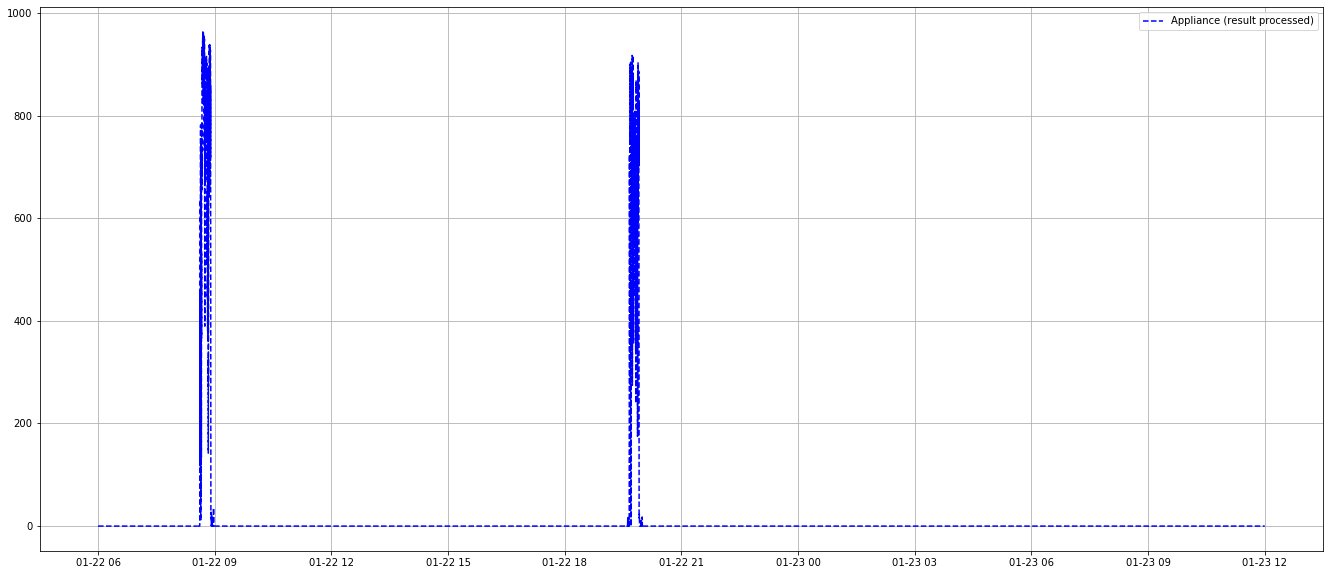

New sensible chunk: 28800
feature selection is done..
Disaggregation is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  88 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished


============ Relative error in total energy: 0.3345037718460949
============ Mean absolute error(in Watts): 6.682873680749344
============ Recall: 0.3834710743801653
============ Precision: 0.08436363636363636
============ Accuracy: 0.8996180555555555
============ F1 Score: 0.138301043219076


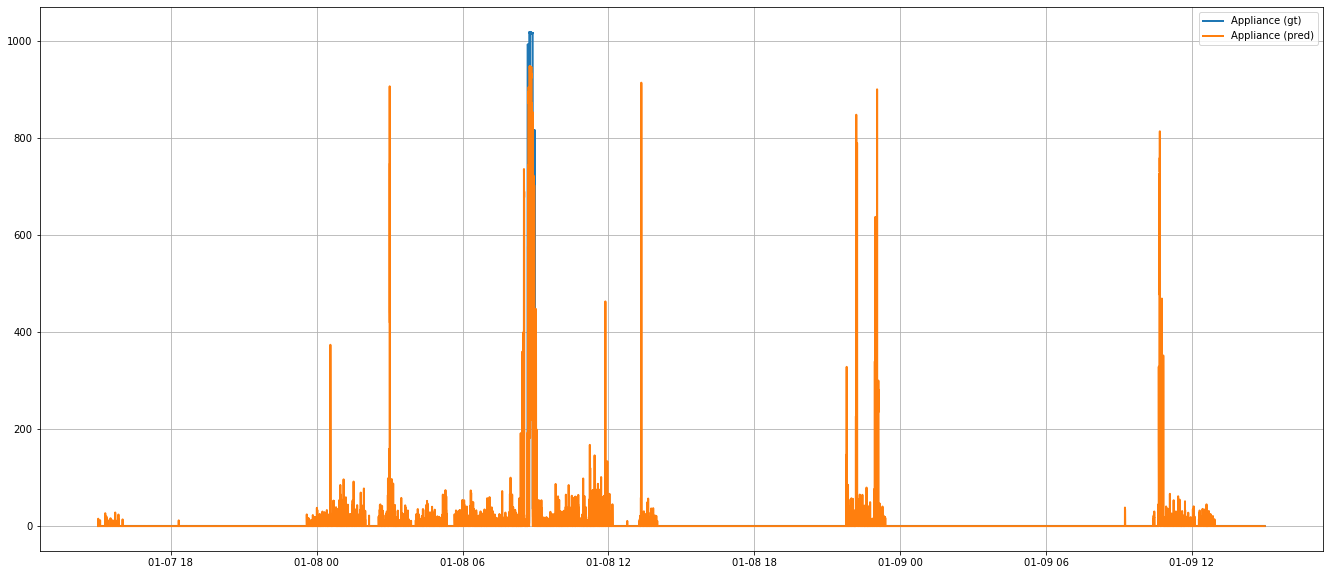

Unix
2017-01-08 00:00:00+09:00     9.300221
2017-01-08 00:01:00+09:00    12.690023
2017-01-08 00:02:00+09:00    16.094430
2017-01-08 00:03:00+09:00    19.240819
2017-01-08 00:04:00+09:00    19.759554
                               ...    
2017-01-09 23:55:00+09:00     2.318910
2017-01-09 23:56:00+09:00     2.085949
2017-01-09 23:57:00+09:00     1.854557
2017-01-09 23:58:00+09:00     1.622495
2017-01-09 23:59:00+09:00     1.390989
Freq: 60S, Name: (power, active), Length: 2880, dtype: float64
# of activations = 1
{'home_id': 9, 'start_idx': '2017-01-08 17:19:00', 'end_idx': '2017-01-08 18:07:00', 'width': 48, 'height': 609}
len=480, cnt=147
tp=1
fp=0
fn=0
tn=2
recall = 1.0
precision = 1.0
accuracy = 1.0
f1 = 1.0


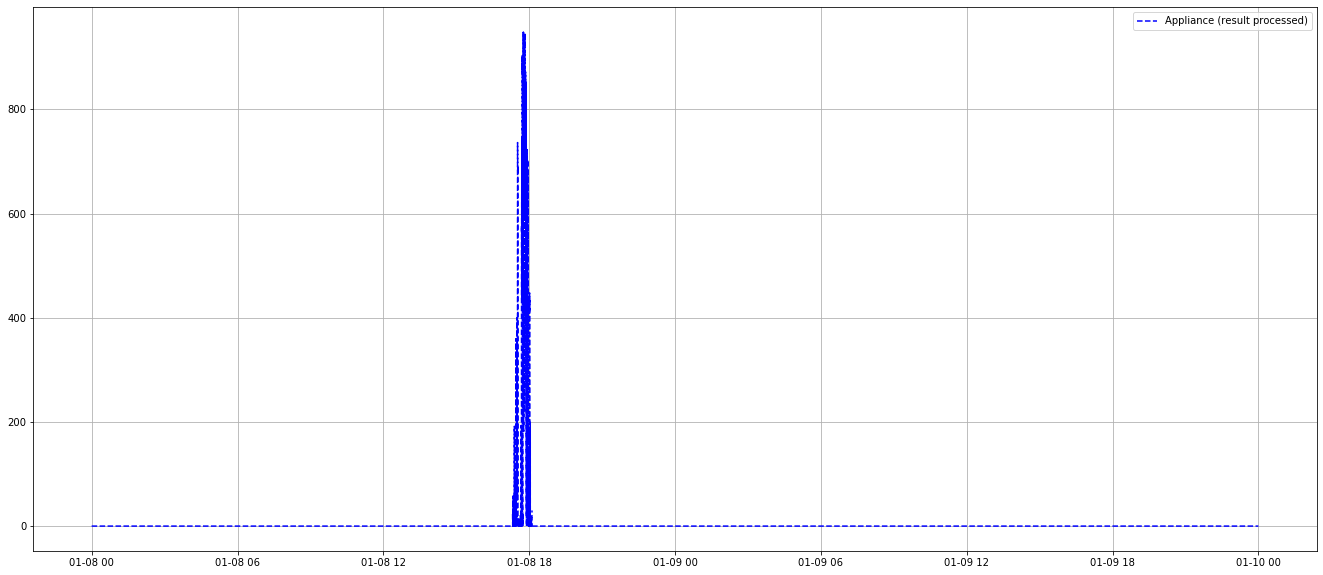

In [18]:
disaggregate(dataset, pretrained_model, 1, target_appliance, '2017-01-22 06:00:00', '2017-01-23 12:00:00', True)
disaggregate(dataset, pretrained_model, 9, target_appliance, '2017-01-08 00:00:00', '2017-01-10 00:00:00', True)